This notebook explores a few different potential models of the Milky Way

In [1]:
import galpy.potential as gp
import arya
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import numpy as np
from astropy import coordinates as coord
from galpy.orbit import Orbit

In [2]:
MN75 = gp.MiyamotoNagaiPotential
ExpDisk = gp.DoubleExponentialDiskPotential
NFW = gp.NFWPotential
plaw = gp.PowerSphericalPotentialwCutoff
Plummer = gp.PlummerPotential

In [3]:
M0 = 1e10*u.Msun
R0 = 1*u.kpc
kms = u.km/u.s
Σ0 = u.Msun / u.pc**2

In [4]:
from astropy.constants import G
galpy_to_standard_force = 1/((2*np.pi*G *u.Msun / u.pc**2).to("km/Myr s"))
print(galpy_to_standard_force)
galpy_to_standard_force = galpy_to_standard_force.value

H0 = 67.74*u.km/u.s/u.Mpc
Ωm = 0.3
ρ_c = 3* H0**2 / (8*np.pi * G )
ρ200 = 200*ρ_c.to("Msun / kpc^3")


36.183087380332516 Myr s / km


In [5]:
def plot_pot(pot, z=0, **kwargs):
    Rs = np.linspace(0.1, 20, 100) * u.kpc
    z = z * u.kpc
    phis = pot(Rs, z)
    plt.plot(Rs, phis)

def plot_pot_2d(pot, R_max=20, z_max=5, R_min=0.001, res=500, **kwargs):
    plt.figure(figsize=(20, 7))
    Rs = np.linspace(R_min, R_max, res) * u.kpc
    zs = np.linspace(0, z_max, res) * u.kpc
    phis = [gp.evaluatePotentials(pot, Rs, z) for z in zs]
    plt.contourf(Rs, zs, phis, levels=round(np.sqrt(res)))
    plt.colorbar()
    plt.gca().set_aspect(1)
    plt.xlabel("R / kpc")
    plt.ylabel("z / kpc")
    
def plot_Vc(pot, R_max=60, R_min=0.01, res=300, **kwargs):
    Rs = np.logspace(np.log10(R_min), np.log10(R_max), res)  * u.kpc
    Vc = gp.calcRotcurve(pot, Rs, 0)
    plt.plot(Rs, Vc, **kwargs)
    plt.xlabel(r"$R$ / kpc")
    plt.ylabel(r"$V_{\rm circ} / \rm km\,s^{-1}$")
    
def plot_Kz(pot, R_max=9, R_min=4, z = 1.1*u.kpc, res=1000, **kwargs):
    Rs = np.linspace(R_min, R_max, res) * u.kpc
    Kz = [ -galpy_to_standard_force * gp.evaluatezforces(pot, r, z).value for r in Rs]
    plt.plot(Rs,Kz, **kwargs)
    plt.yscale("log")
    plt.ylabel(r"Kz / ($2\pi\ G\rm\ M_\odot / pc^2$)")
    plt.xlabel(r"$R$ / kpc")

In [147]:
ngp = coord.SkyCoord.from_name("north galactic pole")
sgp = coord.SkyCoord.from_name("south galactic pole")
sgr_a = coord.SkyCoord.from_name("Sgr A*")

# Sky Positions

In [367]:
sculptor = coord.SkyCoord(ra=15.03917*u.degree, dec=-33.70917*u.degree, 
                         distance=86*u.kpc, radial_velocity=111.4*kms,
                         pm_ra_cosdec=0.099*u.mas/u.year, pm_dec=-0.160*u.mas/u.year)                 

In [368]:
dwarf_galaxy = sculptor

In [369]:

coord.galactocentric_frame_defaults.set("v4.0")

gc_frame = coord.Galactocentric()
dwarf_galaxy_gc = dwarf_galaxy.transform_to(gc_frame)

print(dwarf_galaxy_gc.cartesian.xyz)
print(dwarf_galaxy_gc.velocity.d_xyz)

[ -5.25322919  -9.77133453 -85.37411395] kpc
[ 19.5450337  156.80104562 -94.0252763 ] km / s


In [370]:
gc_frame.galcen_v_sun

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (12.9, 245.6, 7.78)>

In [371]:
o = Orbit(dwarf_galaxy_gc)

In [372]:
dwarf_galaxy_gc.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.099, -0.16, 111.4)>

In [10]:
print(o.x(), o.y(), o.z())
print(o.vx(), o.vy(), o.vz())

5.253229191698499 kpc -9.77133453125754 kpc -85.37411394889955 kpc
-19.545033701266988 km / s 156.801045621668 km / s -94.0252762981455 km / s


note that galpy "x" is -x in astropy's frame

In [12]:
from galpy.util.conversion import get_physical
from galpy.util import conversion as conv

In [13]:
Rgp =  get_physical(o)["ro"]
Vgp =  get_physical(o)["vo"] 

Tgp =  conv.time_in_Gyr( Rgp, Vgp)
Fgp = conv.force_in_2piGmsolpc2(Rgp, Vgp)

In [14]:
def A_NFW(c):
    return (np.log(1+c) - c/(1+c))

def R200_NFW(M200):
    r = ( 3*M200 / (4*np.pi * 200*ρ_c))**(1/3)
    return r.to("kpc")

In [15]:
def Ms_NFW(M200, c):
    return M200 / A_NFW(c)  

In [16]:
R200_NFW(1.04*M0) / 12.5

<Quantity 3.68178142 kpc>

In [17]:
def find_M_c(Ms, Rs, c_i=13):
    c = c_i
    for i in range(100):
        M200 = Ms * A_NFW(c)
        Rv = R200_NFW(M200)
        c = (Rv/Rs).decompose()
    return c, M200

## note about proper motions.

The proper motion of a galaxy on the sky is not directly related to its absolute motion in space.
For example, if a point is not moving, and the reference frame is also stationary, then there is no proper motion:

In [373]:
gc_rest_frame = coord.Galactocentric(galcen_v_sun=[0,0,0]*kms)

In [374]:
dwarf_galaxy_gc = sculptor.transform_to(gc_frame)
dwarf_galaxy_gc = coord.SkyCoord(x=dwarf_galaxy_gc.x, y=dwarf_galaxy_gc.y, z=dwarf_galaxy_gc.z, 
                                 v_x=0*dwarf_galaxy_gc.v_x, v_y=0*dwarf_galaxy_gc.v_y, v_z=0*dwarf_galaxy_gc.v_z, frame=gc_rest_frame)
dwarf_galaxy_gc.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0., 0., 0.)>

however in our moving frame of reference, the proper motion can be substantial:

In [375]:
dwarf_galaxy_gc = sculptor.transform_to(gc_frame)
dwarf_galaxy_gc = coord.SkyCoord(x=dwarf_galaxy_gc.x, y=dwarf_galaxy_gc.y, z=dwarf_galaxy_gc.z, 
                                 v_x=0*dwarf_galaxy_gc.v_x, v_y=0*dwarf_galaxy_gc.v_y, v_z=0*dwarf_galaxy_gc.v_z, frame=gc_frame)
dwarf_galaxy_gc.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.36159063, -0.47548679, 35.20006269)>

this means that a galaxy which has one proper motion may move across the sky in the opposite direction because we are not accounting for the movement of the sun through the milkyway

In [376]:
dwarf_galaxy_gc = sculptor.transform_to(gc_frame)
dwarf_galaxy_gc = coord.SkyCoord(x=dwarf_galaxy_gc.x, y=dwarf_galaxy_gc.y, z=dwarf_galaxy_gc.z, 
                                 v_x=dwarf_galaxy_gc.v_x, v_y=dwarf_galaxy_gc.v_y, v_z=dwarf_galaxy_gc.v_z, frame=gc_rest_frame)
dwarf_galaxy_gc.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.26259063, 0.31548679, 76.19993731)>

In [377]:
sculptor.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.099, -0.16, 111.4)>

in the case of sculptor, this results in a reversal in the sign of both proper motions.

In [379]:
dwarf_galaxy_gc = dwarf_galaxy.transform_to(gc_frame)
dwarf_galaxy_gc.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.099, -0.16, 111.4)>

# Rapha potential model
based on McMillan 2011 (below)

In [18]:
M200 = 126.38*M0
c = 11.2849
Ms = Ms_NFW(M200, c)

Ms

<Quantity 7.94956956e+11 solMass>

In [19]:
# Rv=R200_NFW(M200)
# c = Rv/Rs
# M200 = Ms * A_NFW(c)
# M200.value, c.value

In [20]:
EP2020_thin = MN75(amp=5.9*M0, a=3.944*u.kpc, b=0.311*u.kpc)
EP2020_thick =  MN75(amp=2*M0, a=4.4*u.kpc, b=0.92*u.kpc)

EP2020_halo =  NFW(amp=Ms, a=20.2*u.kpc)
EP2020_bulge = gp.HernquistPotential(amp=2.1 * (2) *M0, a=1.3*u.kpc) # instead of 1.3

EP2020 = EP2020_thin + EP2020_thick + EP2020_halo + EP2020_bulge

# Galpy

In [27]:
M200 = 80*M0
c = 15.3
Ms = Ms_NFW(M200, c)
Ms

<Quantity 4.31845403e+11 solMass>

In [28]:
R200_NFW(M200) / c

<Quantity 12.79269757 kpc>

In [29]:
galpy14_bulge = gp.PowerSphericalPotentialwCutoff(amp=1*M0/u.kpc**3, alpha=1.8, rc=1.9*u.kpc)
galpy14_bulge *= (0.5*M0 / galpy14_bulge.mass(60)).value
galpy14_disk = MN75(amp=6.8*M0, a=3*u.kpc, b=0.28*u.kpc)

galpy14_halo = NFW(amp=Ms, a=16*u.kpc)
galpy14 = galpy14_bulge + galpy14_disk + galpy14_halo
galpy14_heavy = galpy14_bulge + galpy14_disk + 2*galpy14_halo

In [30]:
galpy14_halo.mass(60*u.kpc) + galpy14_disk.mass(60*u.kpc) + galpy14_bulge.mass(60*u.kpc)

<Quantity 4.04733196e+11 solMass>

In [31]:
galpy14_halo.mass(16*u.kpc * c)

<Quantity 8.e+11 solMass>

In [32]:
galpy14_bulge.mass(10)

<Quantity 5.e+09 solMass>

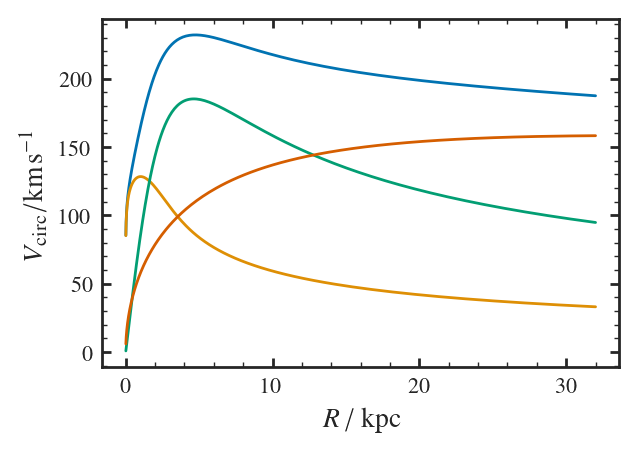

In [33]:
plot_Vc(galpy14, R_max=32)
#plot_Vc(galpy14_heavy, R_max=32)

plot_Vc(galpy14_bulge, R_max=32)
plot_Vc(galpy14_disk, R_max=32)
plot_Vc(galpy14_halo, R_max=32)

# McMillan 2011

In [36]:
def mcmillan_bulge_rho(R, z):
    α=1.8
    r_0 = 0.075/Rgp # kpc
    r_c = 2.1/Rgp # kpc
    q = 0.5
    
    x = np.sqrt(R**2 + (z/q)**2)
    return  1*u.Msun/u.pc**3 / (1 + x/r_0)**α * np.exp(-(x/r_c)**2) 

mcmillan_bulge_unnorm = gp.SCFPotential.from_density(mcmillan_bulge_rho, N=40, symmetry="axisymmetric", a=0.5/Rgp, L=20)


In [37]:
A_mcmillan_bulge = (mcmillan_bulge_rho(0.5/Rgp, 0) / mcmillan_bulge_unnorm.dens(0.5*u.kpc, 0*u.kpc)).value


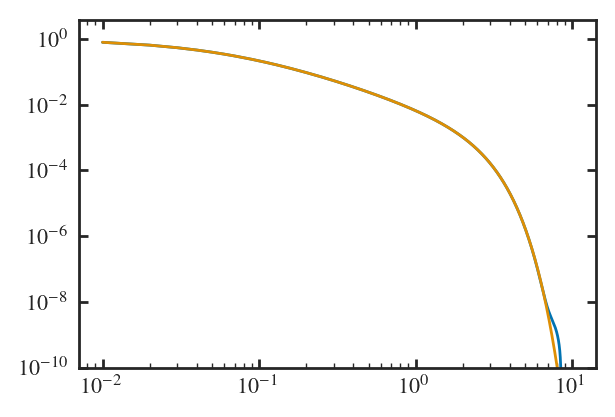

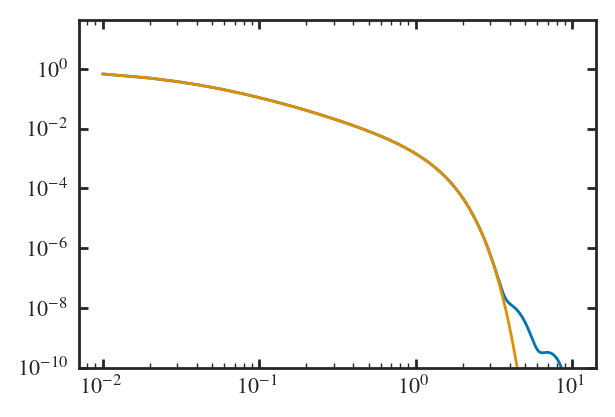

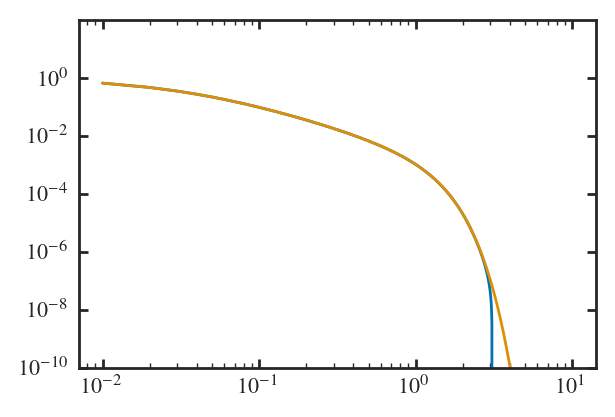

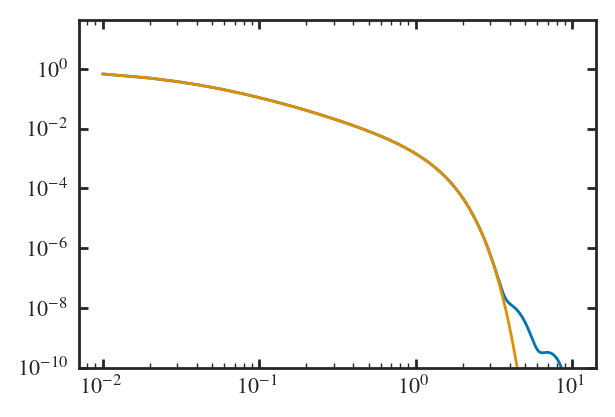

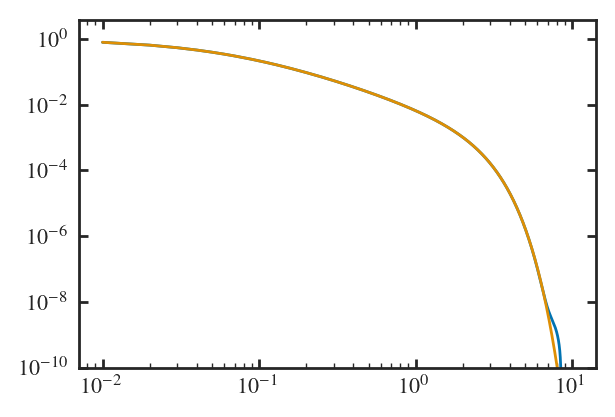

In [38]:
thetas = [0, np.pi/3, np.pi/2, np.pi*2/3, np.pi]
Rs = np.linspace(0.01, 10, 1000) * u.kpc
# test approximation
for theta in thetas:
    rs = Rs * np.cos(theta)
    zs = Rs*np.sin(theta)
    plt.plot(Rs,  A_mcmillan_bulge * mcmillan_bulge_unnorm.dens(rs, zs))
    plt.plot(Rs,  mcmillan_bulge_rho(rs/u.kpc/Rgp, zs/u.kpc/Rgp))

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-10)
    plt.show()

In [39]:
def mcmillan_disk(sigma, r, z):
    return ExpDisk(amp=sigma / z / 2, hr=r, hz=z, )

In [40]:
mcmillan2011_thin = mcmillan_disk(816.6*Σ0, 2.90*u.kpc, 0.3*u.kpc)
mcmillan2011_thick = mcmillan_disk(208*Σ0, 3.31*u.kpc, 0.9*u.kpc)
mcmillan2011_bulge = A_mcmillan_bulge * 95.6 * mcmillan_bulge_unnorm 


rh = 20.2 * u.kpc
rho_h = 0.00846*u.Msun/u.pc**3
Ms = rho_h * 4*np.pi * rh**3 
mcmillan2011_halo = NFW(amp=Ms, a=rh)

mcmillan2011 = mcmillan2011_bulge + mcmillan2011_halo + mcmillan2011_thick + mcmillan2011_thin

/Users/daniel/miniconda3/lib/python3.11/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:19: RuntimeWarning: overflow encountered in sinh
  return (numpy.sinh(numpy.pi * numpy.sinh(t)) + numpy.pi * t * numpy.cosh(t)) / (

/Users/daniel/miniconda3/lib/python3.11/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:20: RuntimeWarning: overflow encountered in cosh
  numpy.cosh(numpy.pi * numpy.sinh(t)) + 1

/Users/daniel/miniconda3/lib/python3.11/site-packages/galpy/potential/DoubleExponentialDiskPotential.py:19: RuntimeWarning: invalid value encountered in divide
  return (numpy.sinh(numpy.pi * numpy.sinh(t)) + numpy.pi * t * numpy.cosh(t)) / (



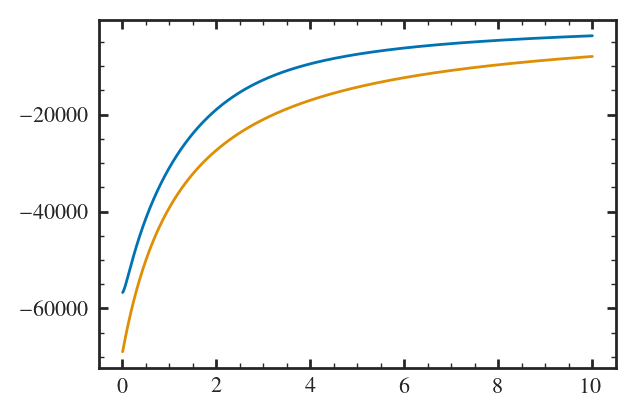

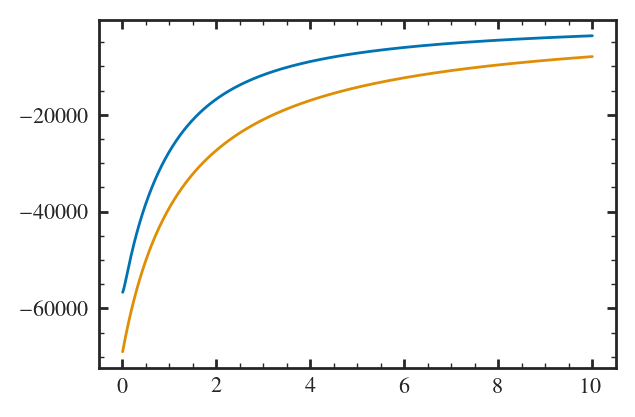

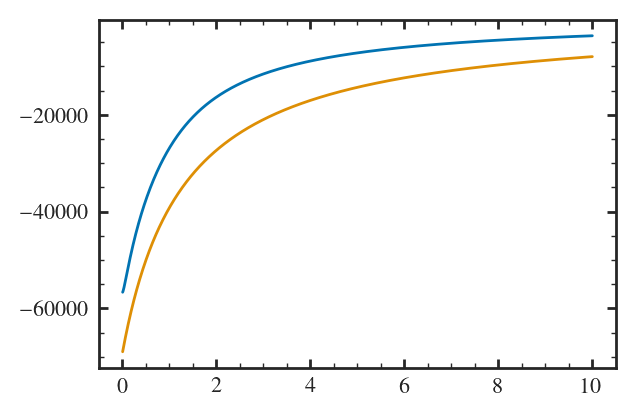

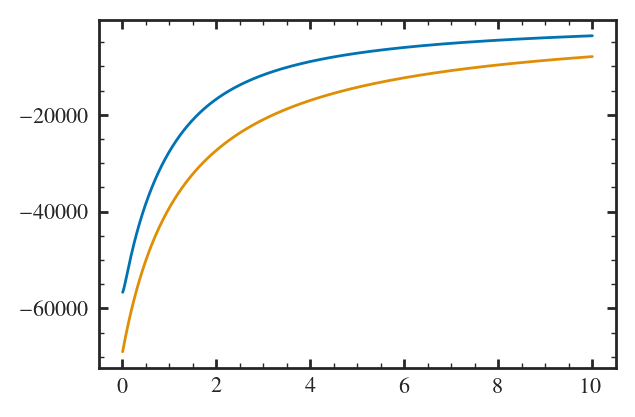

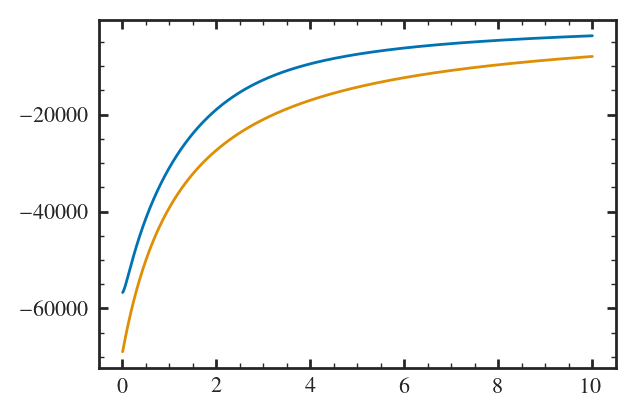

In [41]:
for theta in thetas:
    rs = Rs * np.cos(theta)
    zs = Rs*np.sin(theta)
    plt.plot(Rs, mcmillan2011_bulge(rs, zs))
    plt.plot(Rs, (EP2020_bulge)(rs, zs))
    plt.show()

# McMillan 2017

## Chaos

In [28]:
def mcmillan_gas_rho_model(z_d, R_m, R_d):
    def inner(R, z, phi=0):
        return  1 /(4*z_d) * np.exp(-R_m/R - R / R_d) * np.cosh(z/(2*z_d))**-2
    return inner


h1_rho = mcmillan_gas_rho_model(0.085, 4, 7)
h2_rho = mcmillan_gas_rho_model(0.045, 12, 1.5)

# h1_rho = mcmillan_gas_rho_model(1, 4/7, 1)
# h2_rho = mcmillan_gas_rho_model(1, 7/1.5, 1)


In [599]:
rh = 4
rd = 7
r_z = 0.085


def S(x):
    x = np.array(x)
    return np.where(x<=0, np.nan, np.exp( -rd/x - x/rh))

def hz(z):
    x = z / r_z
    return np.cosh(x)**-2

    
def Hz(z):

    x = z / r_z
    return r_z**2 * (2*x + np.log(np.exp(-2*x) + 1))

def dHz(z):

    x = z/r_z
    return r_z*(-2*np.exp(-2*x)/(np.exp(-2*x) + 1) + 2)

def dSdz(x):
    x = np.array(x)

    return np.where(x<=0, np.nan, -(1/rh - rd/x**2)*np.exp(-rd/x - x/rh))

def dS2dz2(x):
    x = np.array(x)

    return np.where(x<=0, np.nan,
                    (1/rh - rd/x**2)**2*np.exp(-rd/x - x/rh) - 2*rd*np.exp(-rd/x - x/rh)/x**3

                   )

In [646]:
mcmillan_h1_unnorm = gp.DiskSCFPotential(dens=h1_rho, N=20,  L=20, a=7,  
      Sigma={'type':'exp','h':1, 'Rhole':4/7},
      hz={'type':'sech2','h':0.085},
        )

/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10721/2170707423.py:3: RuntimeWarning: overflow encountered in cosh
  return  1 /(4*z_d) * np.exp(-R_m/R - R / R_d) * np.cosh(z/(2*z_d))**-2



In [647]:
mcmillan_h2_unnorm = gp.DiskSCFPotential(dens=h2_rho, N=20,  L=20, a=1, 
      Sigma={'type':'exp','h':1, 'Rhole':12/1.5},
      hz={'type':'sech2','h':0.045},
        )

/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10721/2170707423.py:3: RuntimeWarning: overflow encountered in cosh
  return  1 /(4*z_d) * np.exp(-R_m/R - R / R_d) * np.cosh(z/(2*z_d))**-2



In [673]:
h1_rho(8, 0, 0)

0.5689017782364486

In [648]:
A_mcmillan_h1 = (h1_rho(3, 0, 0) / mcmillan_h1_unnorm.dens(3*u.kpc, 0, 0*u.kpc))
A_mcmillan_h2 = (h2_rho(3, 0, 0) / mcmillan_h2_unnorm.dens(3*u.kpc, 0, 0*u.kpc))

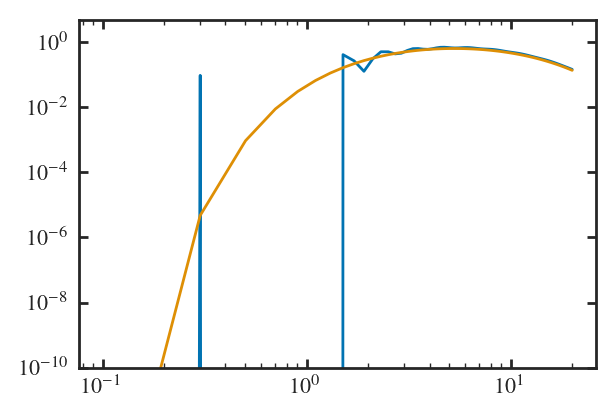

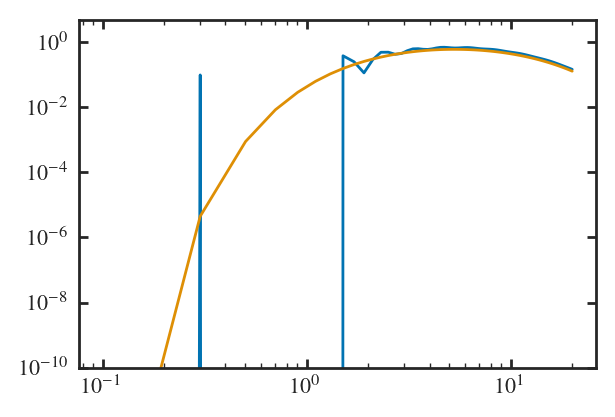

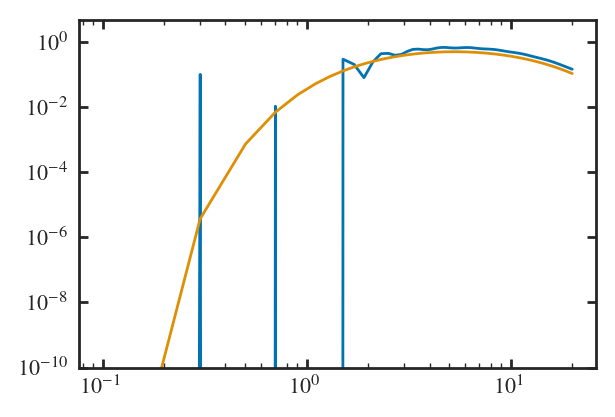

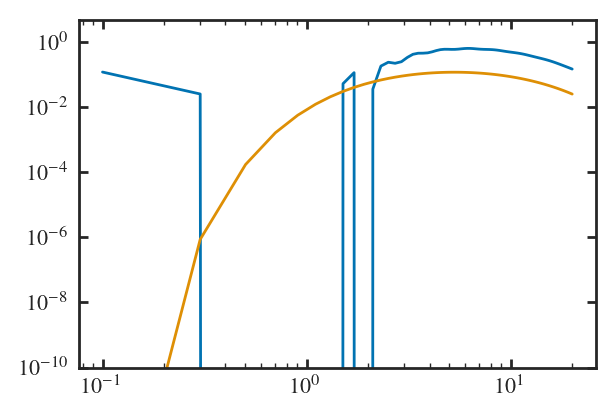

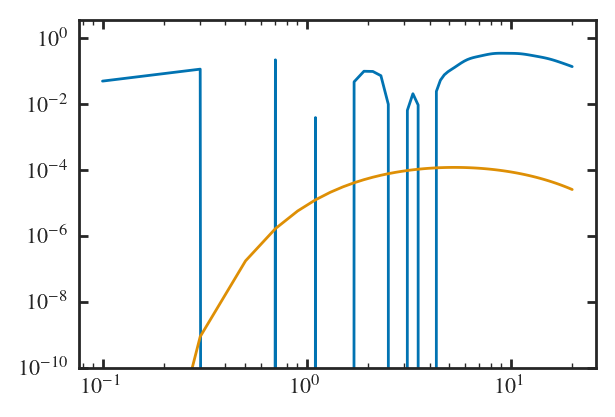

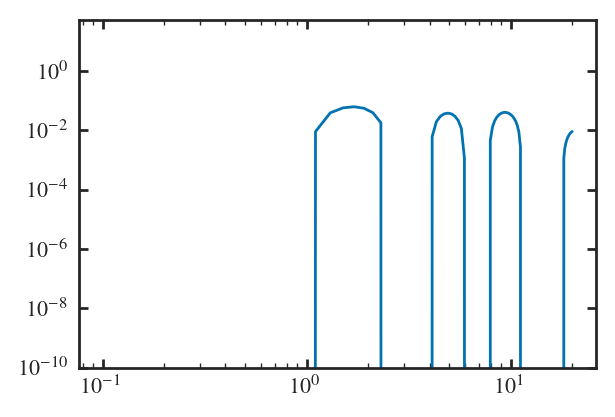

In [649]:
zs = [0, 0.5, 1, 3, 10, 100] *u.kpc* 0.085
# test approximation
for z in zs:
    plt.plot(Rs,  A_mcmillan_h1 * mcmillan_h1_unnorm.dens(Rs, z))
    plt.plot(Rs,  h1_rho(Rs.value, z.value, 3))
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-10)
    plt.show()

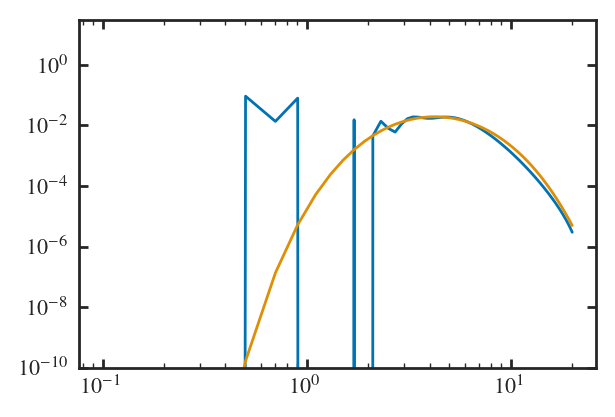

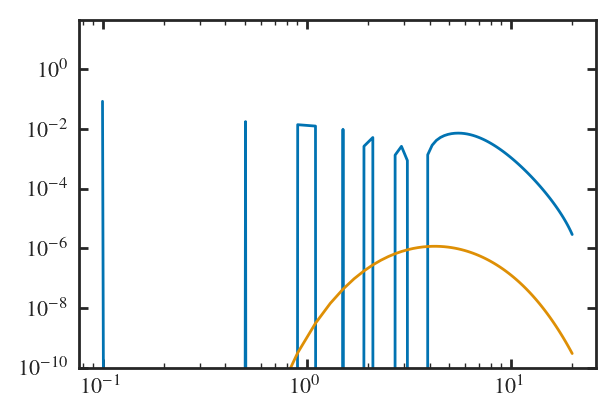

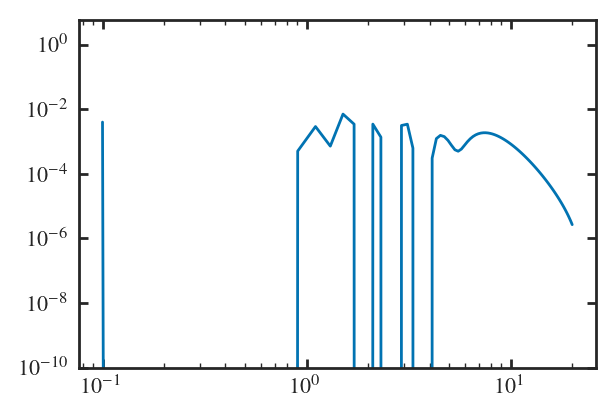

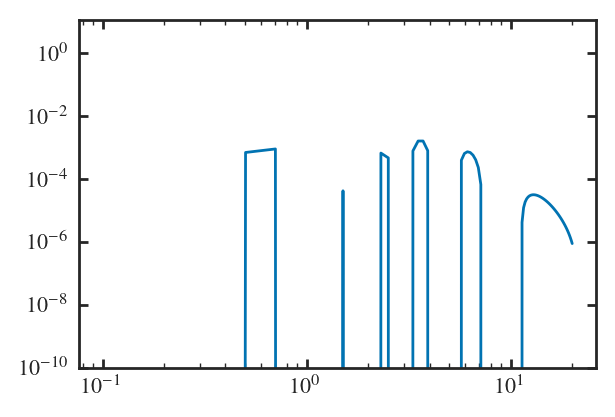

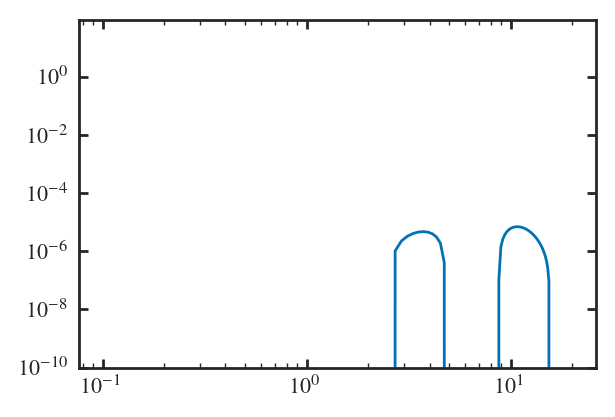

/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10721/2170707423.py:3: RuntimeWarning: overflow encountered in cosh
  return  1 /(4*z_d) * np.exp(-R_m/R - R / R_d) * np.cosh(z/(2*z_d))**-2

/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_10721/2470641736.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")



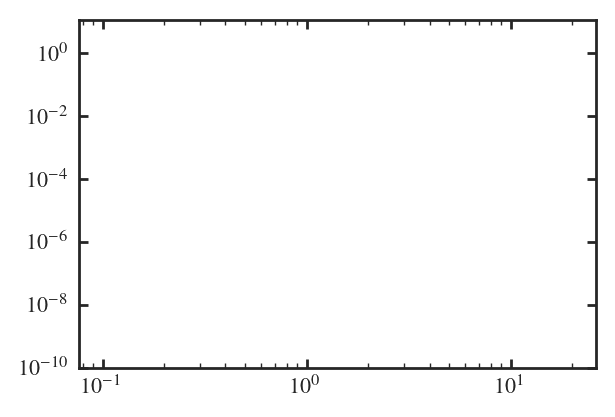

In [650]:
zs = [0, 0.5, 1, 3, 10, 100] * u.kpc
# test approximation
for z in zs:
    plt.plot(Rs,  A_mcmillan_h2 * mcmillan_h2_unnorm.dens(Rs, z))
    plt.plot(Rs,  h2_rho(Rs.value, z.value, 3))
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-10)
    plt.show()

In [ ]:
A_mcmillan_h1 = (h1_rho(3, 0, 0) / mcmillan_h1_unnorm.dens(3*u.kpc, 0, 0*u.kpc))
A_mcmillan_h2 = (h2_rho(3, 0, 0) / mcmillan_h2_unnorm.dens(3*u.kpc, 0, 0*u.kpc))

## normal

In [42]:
mcmillan2017_bulge = A_mcmillan_bulge * 95.6 * mcmillan_bulge_unnorm 
# mcmillan2017_h1 = 53.1*A_mcmillan_h1 * mcmillan_h1_unnorm
# mcmillan2017_h2 = 2380*A_mcmillan_h2 * mcmillan_h2_unnorm

mcmillan2017_h1 = gp.MN3ExponentialDiskPotential(amp=1/3 *53.1*Σ0/(0.085*u.kpc), hr=7*u.kpc, hz=0.085*u.kpc)
mcmillan2017_h2 = gp.MN3ExponentialDiskPotential(amp=1/56 *2380*Σ0/(0.045*u.kpc), hr=1.5*u.kpc, hz=0.045*u.kpc)

mcmillan2017_h1b = gp.RazorThinExponentialDiskPotential(amp=35.7*Σ0, hr=7*u.kpc)
mcmillan2017_h2b = gp.RazorThinExponentialDiskPotential(amp=11.9*Σ0, hr=1.5*u.kpc)


mcmillan2017_thin = mcmillan_disk(886.7*Σ0, 2.53*u.kpc, 0.3*u.kpc)
mcmillan2017_thick = mcmillan_disk(156*Σ0, 3.38*u.kpc, 0.9*u.kpc)


rh = 18.6 * u.kpc
rho_h = 0.0093*u.Msun/u.pc**3
Ms = rho_h * 4*np.pi * rh**3 
mcmillan2017_halo = NFW(amp=Ms, a=rh)

mcmillan2017 = (
    mcmillan2017_bulge 
    + mcmillan2017_halo 
    + mcmillan2017_thick 
    + mcmillan2017_thin 
    + mcmillan2017_h1
    + mcmillan2017_h2
)

mcmillan2017_nogas = (
    mcmillan2017_bulge 
    + mcmillan2017_halo 
    + mcmillan2017_thick 
    + mcmillan2017_thin 
)



In [43]:
mcmillan2017_bulge.mass(100*u.kpc)

<Quantity 8.62491073e+09 solMass>

In [44]:
(2*np.pi * 886.7*Σ0 * ( 2.53*u.kpc)**2).to("Msun")

<Quantity 3.56613368e+10 solMass>

In [45]:
0.862 + 3.566 + 1.119 # stellar mass is correct

5.547

In [46]:
mcmillan2017_halo.dens(8.2*u.kpc, 0)

<Quantity 0.01016104 solMass / pc3>

In [47]:
gp.evaluatezforces(mcmillan2017, 8.2*u.kpc, z=1.1*u.kpc) * galpy_to_standard_force

<Quantity -76.07108429 km / (Myr s)>

In [48]:
sum([a.mass(100*u.kpc) for a in mcmillan2017])

<Quantity 8.26274509e+11 solMass>

In [49]:
(np.pi * 2 * (156*Σ0) * (3.38*u.kpc)**2).to("Msun")

<Quantity 1.11979331e+10 solMass>

In [50]:
mcmillan2017_thick.mass(1000)

<Quantity 1.11979333e+10 solMass>

In [51]:
(2*np.pi * 53.1*Σ0 * (7*u.kpc)**2).to("Msun")

<Quantity 1.63482199e+10 solMass>

In [52]:
mcmillan2017_h1.mass(50*u.kpc)

<Quantity 1.09678815e+10 solMass>

In [53]:
mcmillan2017_h2.mass(10*u.kpc)

<Quantity 1.20773002e+09 solMass>

In [54]:
mcmillan2017_bulge.mass(10000*u.kpc)

<Quantity 8.62499359e+09 solMass>

In [55]:
mcmillan2017_h1b.mass(1000)

<Quantity 1.09911761e+10 solMass>

In [56]:
mcmillan2017_h2b.mass(10000)

<Quantity 1.68232287e+08 solMass>

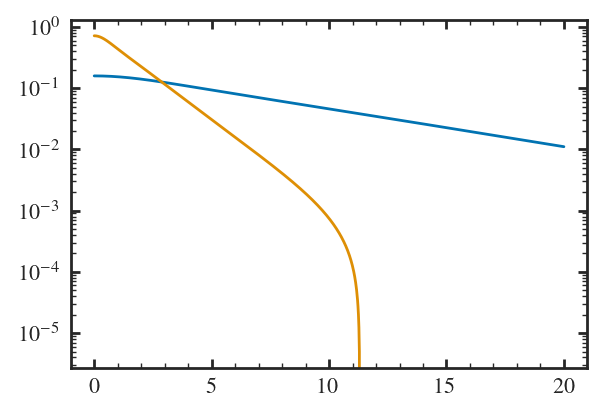

In [57]:
Rs = np.linspace(0, 20, 1000)*u.kpc
plt.plot(Rs, mcmillan2017_h1.dens(Rs, 0*u.kpc))
plt.plot(Rs, mcmillan2017_h2.dens(Rs, 0*u.kpc))

plt.yscale("log")

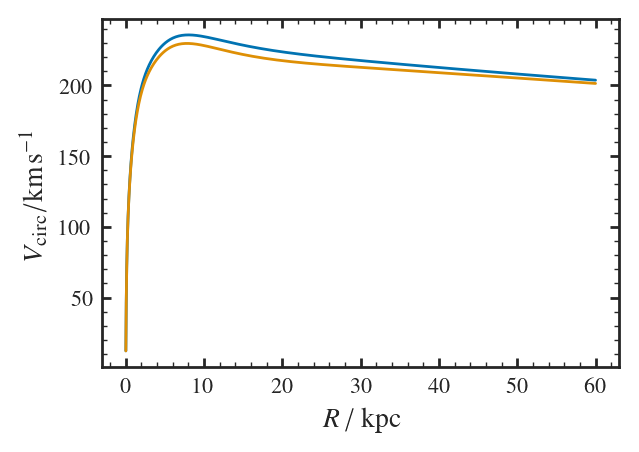

In [58]:
plot_Vc(mcmillan2017, label="thick")
plot_Vc(mcmillan2017_nogas, label="thick")


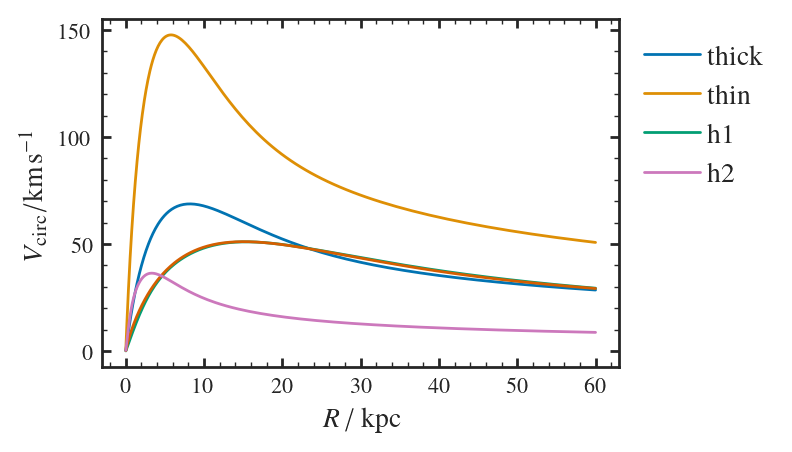

In [59]:
plot_Vc(mcmillan2017_thick, label="thick")
plot_Vc(mcmillan2017_thin, label="thin")


plot_Vc(mcmillan2017_h1, label="h1")
plot_Vc(mcmillan2017_h1b, )

plot_Vc(mcmillan2017_h2,label="h2")
arya.Legend(loc=-1)


# Pouliasis 17 model

In [60]:
Mp = 2.32e7*u.Msun
pouliasis17_bulge = Plummer(amp=460*Mp, b=0.3*u.kpc)
pouliasis17_thin = MN75(amp=1700*Mp, a=5.3*u.kpc, b=0.25*u.kpc)
pouliasis17_thick = MN75(amp=1700*Mp, a=2.6*u.kpc, b=0.8*u.kpc)
ah = 14*u.kpc
Mh = 6000*Mp
pouliasis17_halo = 2*NFW(amp=Mh, a=ah) + gp.TwoPowerSphericalPotential(alpha=0, beta=2, amp=Mh, a=ah)

pouliasis17 = pouliasis17_bulge + pouliasis17_thin + pouliasis17_thick + pouliasis17_halo

In [61]:
pouliasis17b_thin = MN75(amp=1600*Mp, a=4.8*u.kpc, b=0.25*u.kpc)
pouliasis17b_thick = MN75(amp=1700*Mp, a=2.0*u.kpc, b=0.8*u.kpc)
ah = 14*u.kpc
Mh = 9000*Mp
pouliasis17b_halo = 2*NFW(amp=Mh, a=ah) + gp.TwoPowerSphericalPotential(alpha=0, beta=2, amp=Mh, a=ah)

pouliasis17b = pouliasis17b_thin + pouliasis17b_thick + pouliasis17b_halo

# Ablimit + 2020

builds on pouliasis but with NFW halo and more recent (cephied) data. Very close to galpy.

In [62]:
R200_NFW(M200) / c

<Quantity 12.79269757 kpc>

In [63]:
M200 = 66.3*M0
c = 12.36
Ms = Ms_NFW( M200, c)

Rs = 14.45*u.kpc
Ms

<Quantity 3.97692909e+11 solMass>

In [64]:
find_M_c(Ms, Rs)

(<Quantity 12.7988275>, <Quantity 6.74906163e+11 solMass>)

In [65]:
M200 = 6.749*M0
c = 12.7988
Ms = Ms_NFW(M200, c)

In [66]:
Ms

<Quantity 3.97689711e+10 solMass>

In [67]:
ablimit_c = {
    "halo": NFW(amp=Ms, a=Rs),
    "disk": pouliasis17_thick + pouliasis17_thin,
    "bulge": pouliasis17_bulge,
}

ablimit20a = [val for key, val in ablimit_c.items()]




In [68]:
M200 = 82.2*M0
c = 13.04
Ms = Ms_NFW(M200, c)
ablimit_b_comp = {
    "halo": NFW(amp=Ms, a=14.71*u.kpc),
    "disk": pouliasis17_thick + pouliasis17_thin,
    "bulge": pouliasis17_bulge,
}

ablimit20b = [val for key, val in ablimit_b_comp.items()]


In [69]:
R200_NFW(M200) / c

<Quantity 15.14618472 kpc>

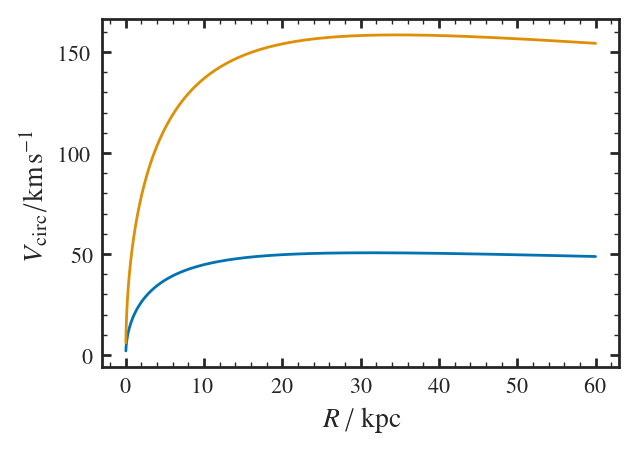

In [70]:
plot_Vc(ablimit_c["halo"])
plot_Vc(galpy14_halo)

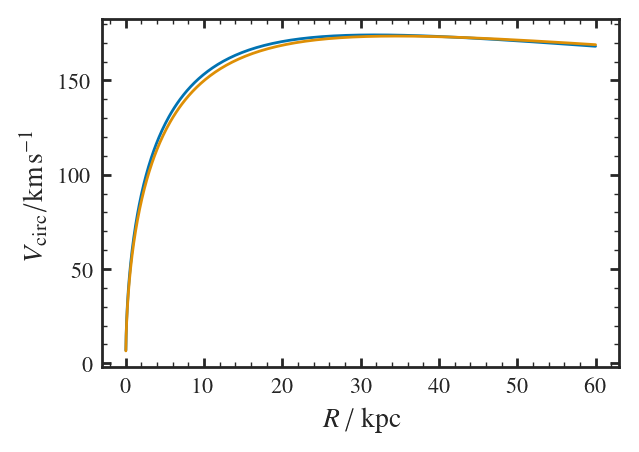

In [71]:
plot_Vc(ablimit_b_comp["halo"])
plot_Vc(1.2*galpy14_halo)

# Shen 2022

In [72]:
4*np.pi * M0 / (207.0*u.kpc)**3

<Quantity 14167.68289043 solMass / kpc3>

In [73]:
shen22_halo = gp.PowerSphericalPotential(amp=0.2275*M0, r1=1*u.kpc, alpha=2+0.43)


c=12
R200=207*u.kpc
Ms = Ms_NFW(105*M0, c) # is 95 in paper but not described well...
shen22_halo_b = NFW(amp=Ms, a=R200/c)

In [74]:
conv.mass_in_1010msol(vo=Vgp, ro=Rgp)

0.00018884281784973248

In [80]:
shen22_halo.mass(250*u.kpc) / M0

<Quantity 116.71917637>

In [76]:
shen22_halo_b.mass(R200) 

<Quantity 1.05e+12 solMass>

In [78]:
shen22_halo.mass(10*u.kpc) / M0

<Quantity 18.63444272>

In [79]:
shen22_halo.mass(100*u.kpc) / M0

<Quantity 69.23351946>

In [80]:
shen22_halo.mass(250*u.kpc) / M0

<Quantity 116.71917637>

In [81]:
Rs = np.linspace(10, 250, 1000) * u.kpc

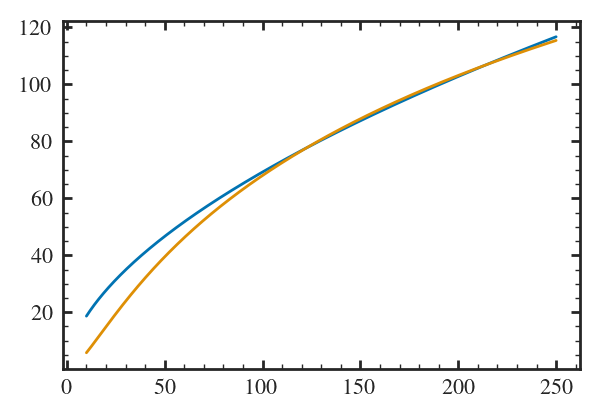

In [82]:
plt.plot(Rs, [shen22_halo.mass(R) / M0 for R in Rs])
plt.plot(Rs, [shen22_halo_b.mass(R) / M0 for R in Rs])

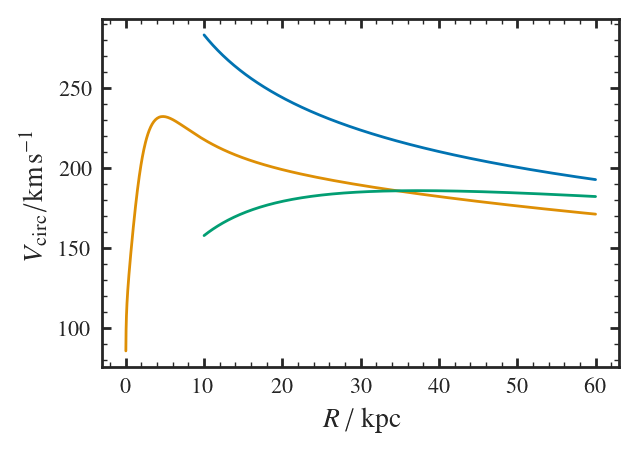

In [83]:
plot_Vc(shen22_halo, R_min=10)
plot_Vc(galpy14)
plot_Vc(shen22_halo_b, R_min=10)

# Nitschai 

In [84]:
nitschai_halo = gp.TwoPowerTriaxialPotential(amp=41.1*M0, alpha=1.53, beta=3, a=16.8*u.kpc, c=1.14)
nitschai_halo_b = gp.TwoPowerSphericalPotential(amp=44.1*M0, alpha=1.53, beta=3, a=16.8*u.kpc)

In [85]:
Mh = nitschai_halo.mass(8.2*u.kpc)

In [86]:
nitschai_halo.dens(8.2*u.kpc, 0*u.kpc)

<Quantity 0.01152192 solMass / pc3>

In [87]:
Mh / (Mh + mcmillan2017_halo.mass(8.2*u.kpc) + mcmillan2017_thick.mass(8.2*u.kpc) +  mcmillan2017_thin.mass(8.2*u.kpc))

<Quantity 0.4867885>

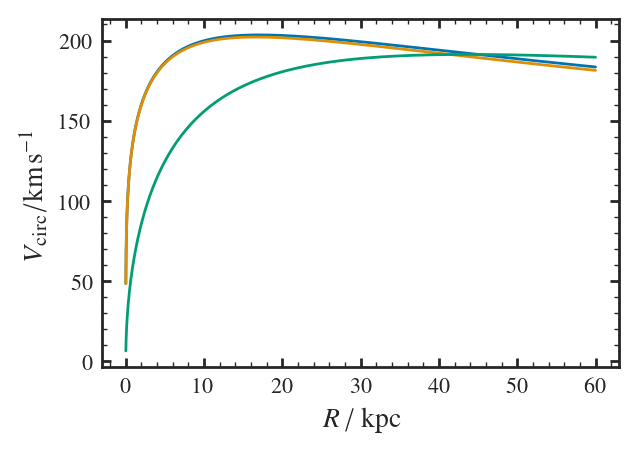

In [88]:
plot_Vc(nitschai_halo)
plot_Vc(nitschai_halo_b)

plot_Vc(EP2020_halo)

In [89]:
nitschai = nitschai_halo + mcmillan2017_bulge + mcmillan2017_thick + mcmillan2017_thick + mcmillan2017_h1 + mcmillan2017_h2
nitschai_b = nitschai_halo_b + mcmillan2017_bulge + mcmillan2017_thick + mcmillan2017_thick + mcmillan2017_h1 + mcmillan2017_h2

In [90]:
mcmillan2017_thin.mass(100)

<Quantity 3.56613726e+10 solMass>

In [91]:
mcmillan2017_h2b.surfdens(1, 0)

<Quantity 0.05296571 solMass / pc2>

In [92]:
(mcmillan2017_thick.dens(1, 0) + mcmillan2017_thin.dens(1, 0)) / (0.3*u.Msun/u.Lsun) / (1.12)

<Quantity 0.20078433 solLum / pc3>

In [93]:
A_disk = 0.056 / 0.2

(200.0, 250.0)

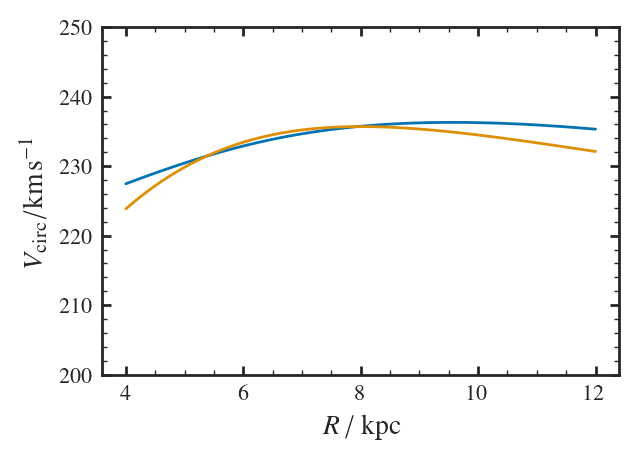

In [94]:
plot_Vc(nitschai, R_min=4, R_max=12)
plot_Vc(mcmillan2017, R_min=4, R_max=12)

plt.ylim(200, 250)

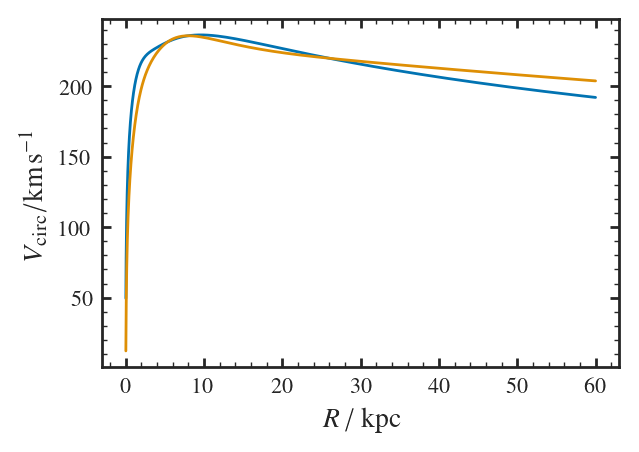

In [95]:
plot_Vc(nitschai)
plot_Vc(mcmillan2017) #only difference is halo


# Extra pots

In [34]:
Ms = 105*M0
r_s = 20.2*u.kpc
heavy_halo = NFW(amp=Ms, a=r_s)
find_M_c(Ms, r_s)

(<Quantity 12.6248736>, <Quantity 1.76955685e+12 solMass>)

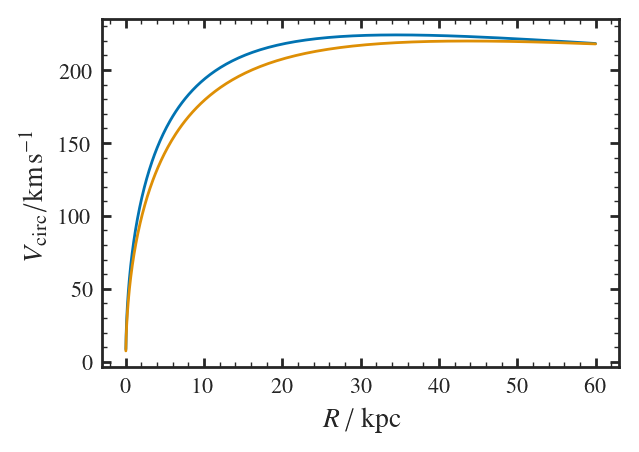

In [35]:
plot_Vc(2*galpy14_halo)
plot_Vc(heavy_halo)

In [36]:
Ms = 60*M0
r_s = 20.2*u.kpc
light_halo = NFW(amp=Ms, a=r_s)
find_M_c(Ms, r_s)

(<Quantity 10.06428194>, <Quantity 8.96461799e+11 solMass>)

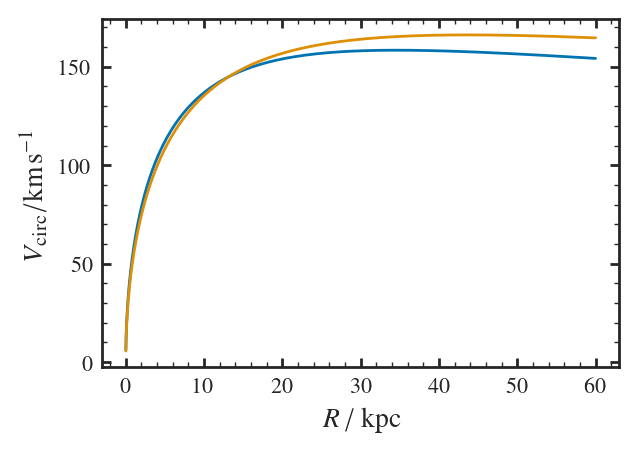

In [37]:
plot_Vc(galpy14_halo)
plot_Vc(light_halo)

In [38]:
Ms = 130*M0
r_s = 33*u.kpc
me_flat_halo =  NFW(amp=Ms, a=r_s)
me_flat = EP2020_thin + EP2020_thick + EP2020_bulge + me_flat_halo

find_M_c(Ms, r_s)

(<Quantity 7.53394123>, <Quantity 1.63959959e+12 solMass>)

NameError: name 'pouliasis17_halo' is not defined

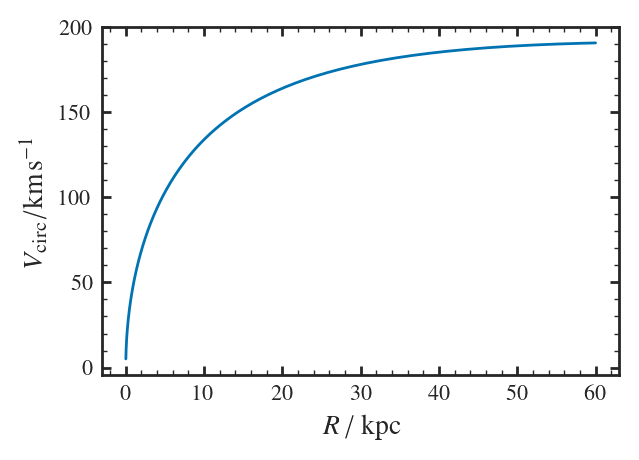

In [39]:
plot_Vc(me_flat_halo)
#plot_Vc(EP2020_halo)
plot_Vc(pouliasis17_halo)

In [40]:
Ms = 45*M0
r_s = 10*u.kpc
me_steep_halo =  NFW(amp=Ms, a=r_s)

me_steep = EP2020_thin + EP2020_thick + EP2020_bulge + me_steep_halo

find_M_c(Ms, r_s)

(<Quantity 20.77804385>, <Quantity 9.57069048e+11 solMass>)

NameError: name 'nitschai_halo' is not defined

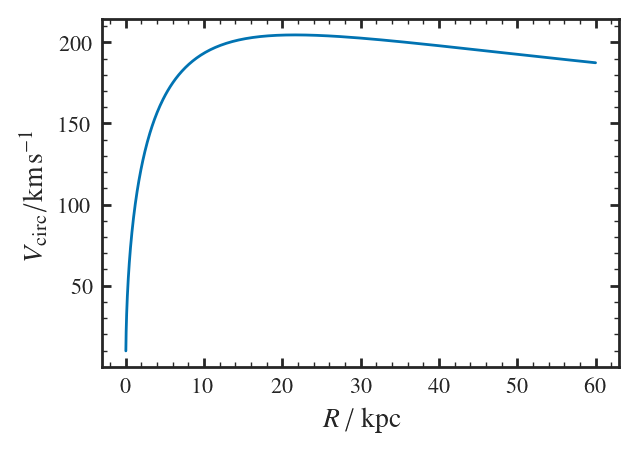

In [41]:
plot_Vc(me_steep_halo)
#plot_Vc(EP2020_halo)
plot_Vc(nitschai_halo)

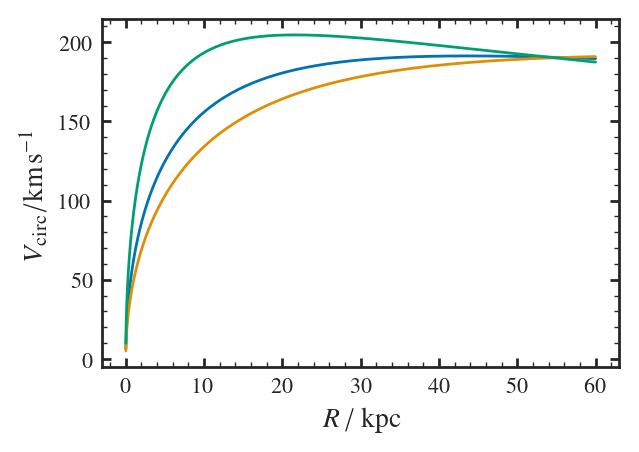

In [104]:
plot_Vc(EP2020_halo)
plot_Vc(me_flat_halo)
plot_Vc(me_steep_halo)


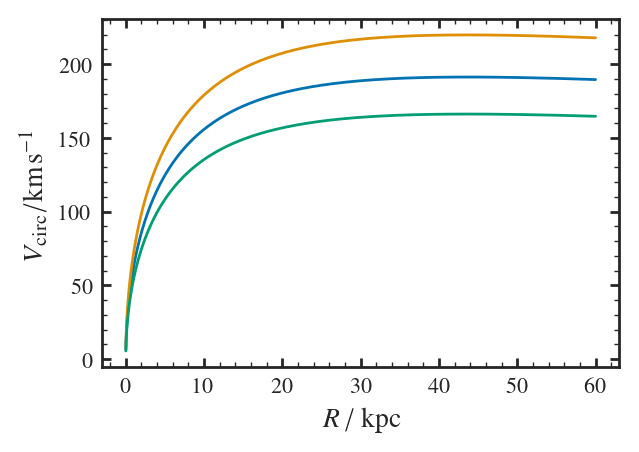

In [105]:
plot_Vc(EP2020_halo)
plot_Vc(heavy_halo)
plot_Vc(light_halo)

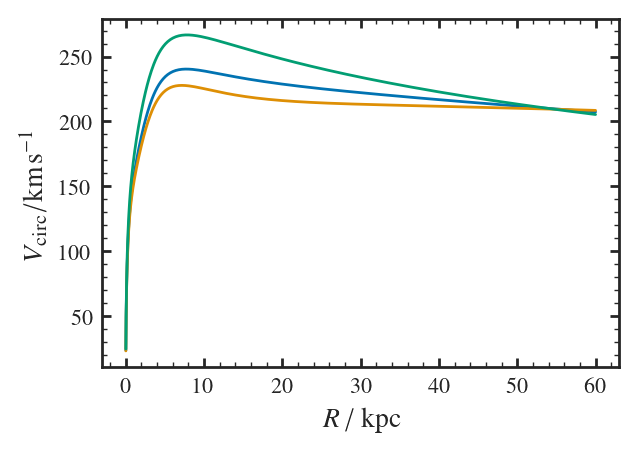

In [106]:
plot_Vc(EP2020)
plot_Vc(me_flat)
plot_Vc(me_steep)


In [107]:
heavy_mw = EP2020_bulge + EP2020_thin + EP2020_thick + heavy_halo
light_mw = EP2020_bulge + EP2020_thin + EP2020_thick + light_halo

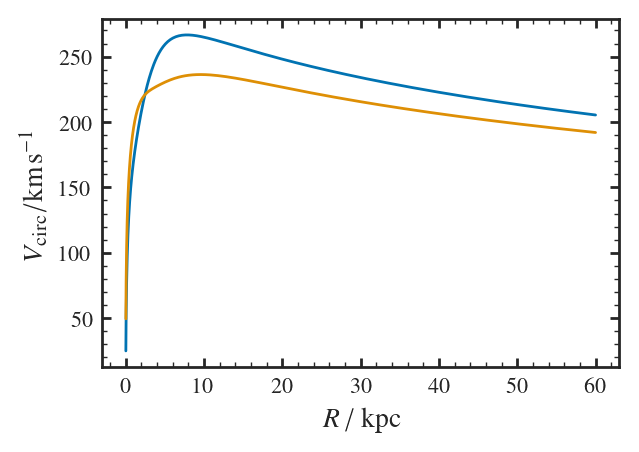

In [108]:
plot_Vc(me_steep)
plot_Vc(nitschai)

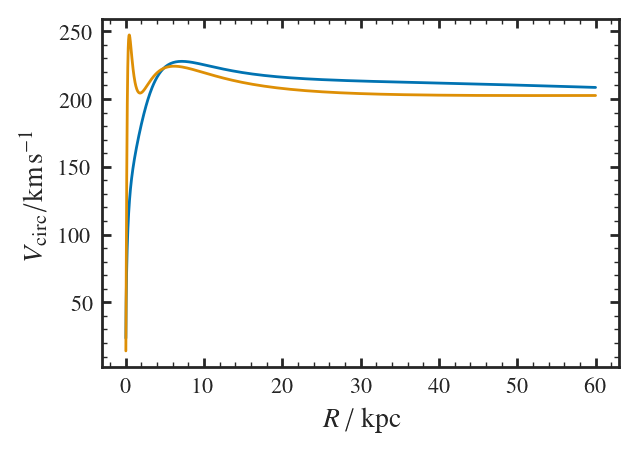

In [109]:
plot_Vc(me_flat)
plot_Vc(pouliasis17)

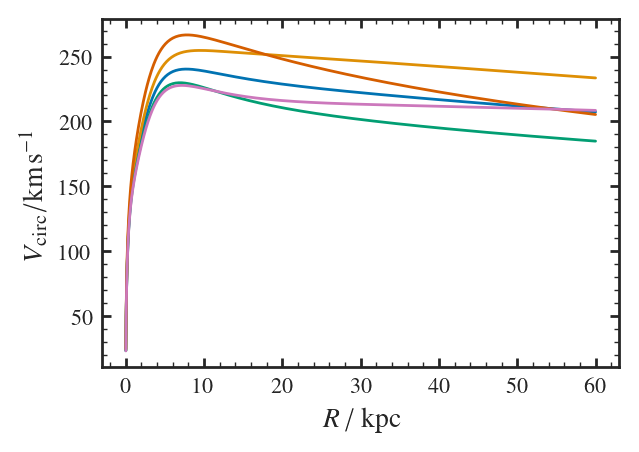

In [110]:
plot_Vc(EP2020)
plot_Vc(heavy_mw)
plot_Vc(light_mw)
plot_Vc(me_steep)
plot_Vc(me_flat)

# Comparisons

In [159]:
potentials = {
    "EP20": EP2020,
    #"mcmillan11": mcmillan2011, # mcmillan is very close to EP2020
    #"mcmillan17": mcmillan2017,
    #"mcmillan17b": mcmillan2017_nogas,
    "galpy14": galpy14,
    # "galpy14_heavy": galpy14_heavy,
    # "pouliaris17": pouliasis17,
    # #"pouliaris17b": pouliasis17b,
    # "ablimit": ablimit20a,
    # "flat": me_flat,

}

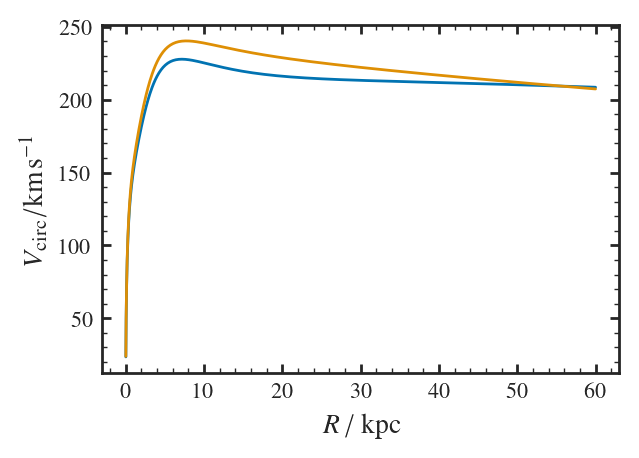

In [160]:
plot_Vc(me_flat)
plot_Vc(EP2020)

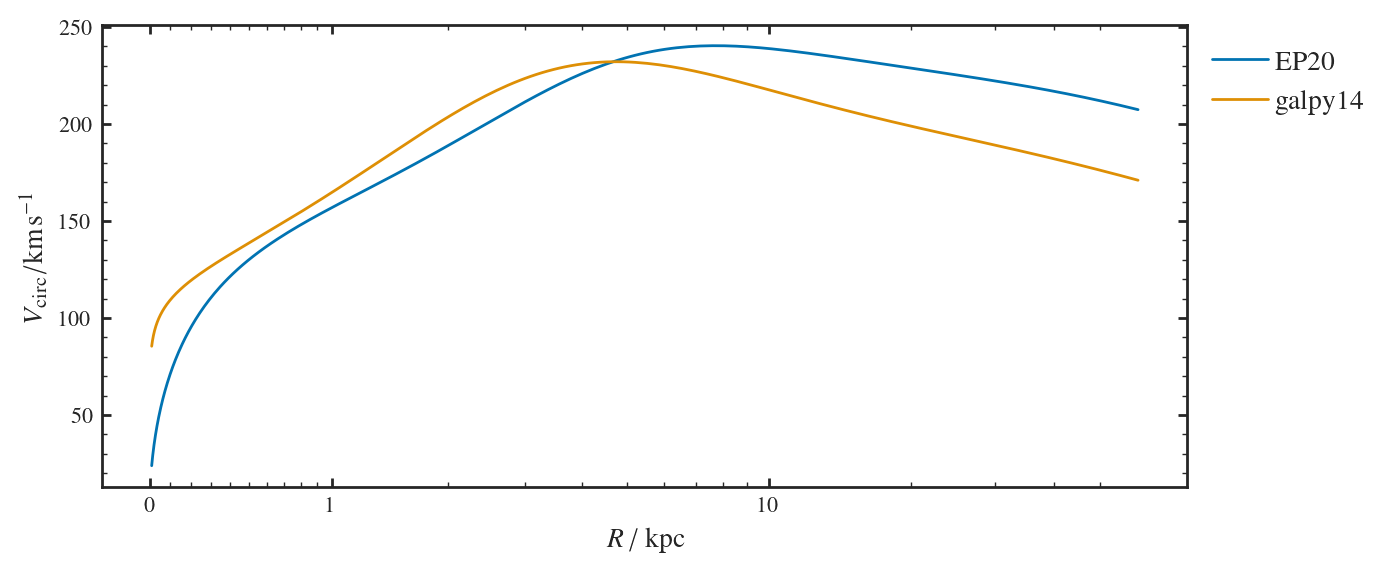

In [161]:
plt.figure(figsize=(7, 3))
for label, model in potentials.items():
    plot_Vc(model, label=label, R_max=60)
arya.Legend(loc=-1)
plt.xscale("asinh")

ticks = [0,1, 10]
plt.xticks(ticks, labels=ticks);

mticks = np.arange(0, 1, 0.1).tolist() + np.arange(1, 10, 1).tolist() + np.arange(10, 60, 10).tolist()
plt.xticks(mticks, minor=True);
plt.savefig("literature_vcirc.pdf")

NameError: name 'heavy_mw' is not defined

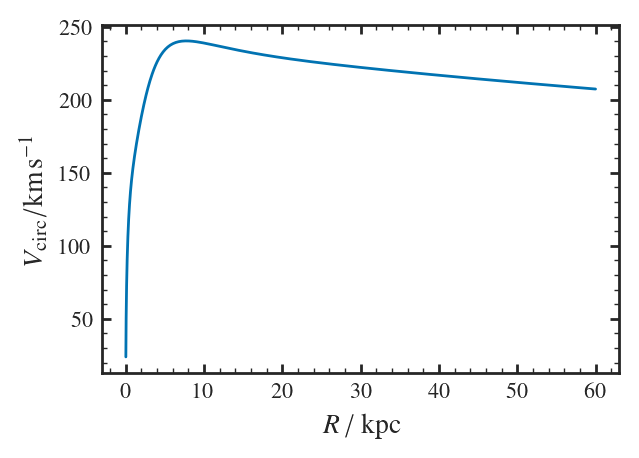

In [162]:
plot_Vc(EP2020)
plot_Vc(heavy_mw)
plot_Vc(light_mw)
plot_Vc(me_steep)
plot_Vc(me_flat)
plt.xscale("asinh")


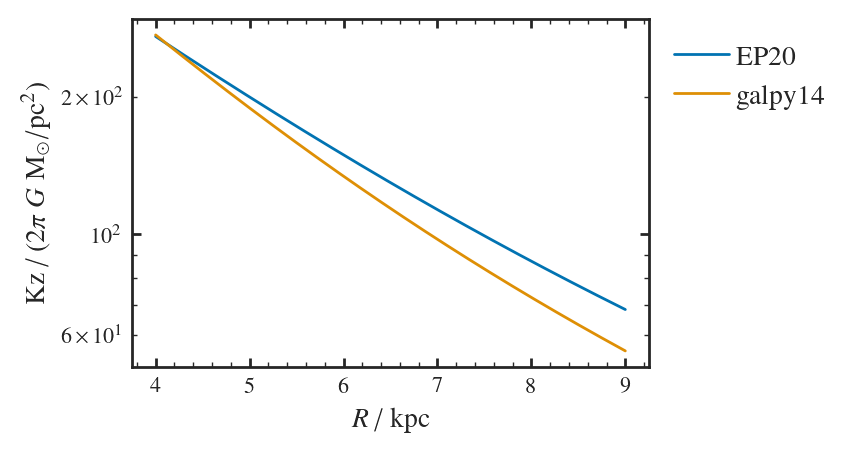

In [47]:
# acceleration at 1.1 kpc above plane
for label, model in potentials.items():
    plot_Kz(model, label=label)
arya.Legend(loc=-1)

## Components

In [117]:
my_potentials = {
    "fiducial": EP2020,
    "light": light_mw,
    "heavy": heavy_mw,
    "flat": me_flat,
    "steep": me_steep
}

In [118]:
for label, pot in my_potentials.items():
    print(label, o.jr(pot))

fiducial 2356.218626155039 km kpc / s
light 3023.6303502335577 km kpc / s
heavy 1948.189066408485 km kpc / s
flat 2612.867728692147 km kpc / s
steep 2080.8772622403267 km kpc / s


In [119]:
o.jr(galpy14)

<Quantity 3665.6712867 km kpc / s>

In [120]:
o.jr(galpy14_heavy)

<Quantity 1944.95200358 km kpc / s>

In [121]:
o.jr(EP2020)

<Quantity 2356.21862616 km kpc / s>

In [122]:
o.jr(ablimit20a)

<Quantity 81219.65244149 km kpc / s>

In [123]:
o.jr(mcmillan2017)

<Quantity 2444.67300641 km kpc / s>

In [124]:
for label, pot in my_potentials.items():
    print(label, o.jz(pot))

fiducial 2034.7868236764687 km kpc / s
light 2035.0462780639152 km kpc / s
heavy 2034.5353668299974 km kpc / s
flat 2036.1601145359427 km kpc / s
steep 2032.5380153020458 km kpc / s


In [125]:
o.jz(galpy14)

<Quantity 1999.04230236 km kpc / s>

In [126]:
o.jz(galpy14_heavy)

<Quantity 1998.43630531 km kpc / s>

In [127]:
o.jz(EP2020)

<Quantity 2034.78682368 km kpc / s>

In [128]:
o.jz(mcmillan2017)

<Quantity 1991.00247201 km kpc / s>

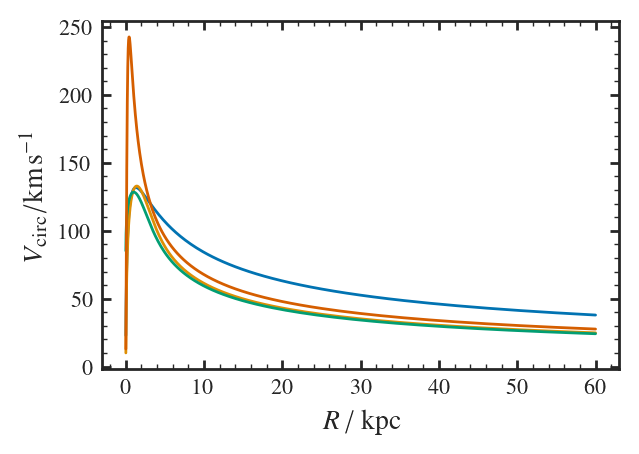

In [129]:
plot_Vc(EP2020_bulge)
plot_Vc(mcmillan2011_bulge)
plot_Vc(galpy14_bulge)
plot_Vc(pouliasis17_bulge)

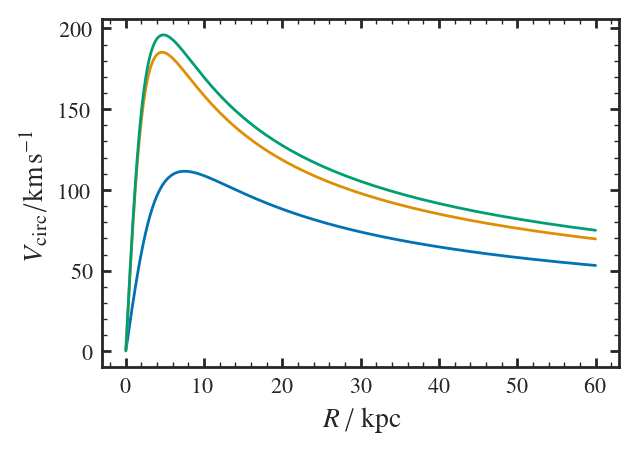

In [130]:
plot_Vc(EP2020_thick + EP2020_thick)
plot_Vc(galpy14_disk)
# plot_Vc(galpy14_disk)

plot_Vc(pouliasis17_thick + pouliasis17_thick)
# plot_Vc(pouliasis17b_thick + pouliasis17b_thick)

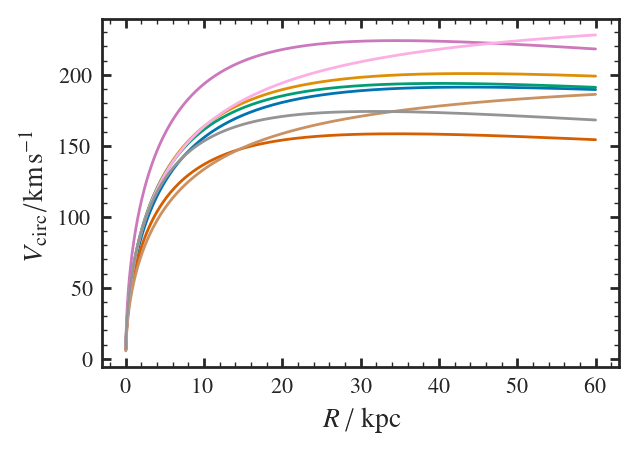

In [131]:
plot_Vc(EP2020_halo)
plot_Vc(mcmillan2011_halo)
plot_Vc(mcmillan2017_halo)
plot_Vc(galpy14_halo)
plot_Vc(2*galpy14_halo)

plot_Vc(pouliasis17_halo)
plot_Vc(pouliasis17b_halo)
plot_Vc(ablimit_b_comp["halo"]) # pretty much same as galpy


# Detailed orbit

In [380]:
dwarf_galaxy_gc.icrs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (15.03917, -33.70917, 86.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.099, -0.16, 111.4)>

In [381]:
o = Orbit(dwarf_galaxy_gc)

In [382]:
pot = EP2020
ts = np.linspace(0, -5, 10_000) * u.Gyr
o.integrate(ts, pot)

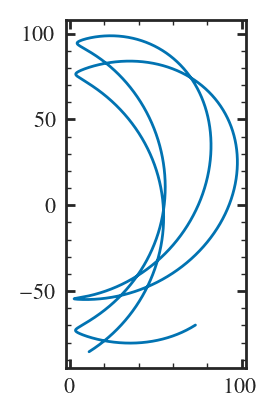

In [383]:
fig, ax = plt.subplots()

plt.plot(o.R(ts), o.z(ts))
ax.set_aspect(1)

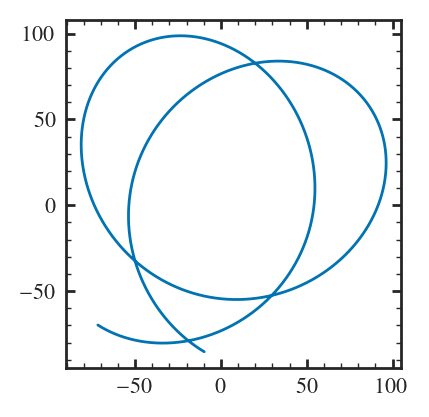

In [384]:
fig, ax = plt.subplots()

plt.plot(o.y(ts), o.z(ts))

ax.set_aspect(1)

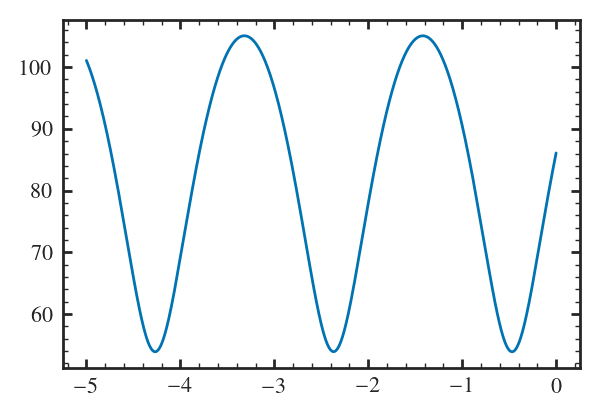

In [385]:
plt.plot(ts, o.r(ts))

In [386]:
pos_gc = []

ts = np.linspace(0, 0.1, 10_000) * u.Gyr
o.integrate(ts, pot)

# galpy uses left-handed frame :/
pos_gc = coord.SkyCoord(
    x=- o.x(ts), y=o.y(ts), z=o.z(ts), 
    v_x = -o.vx(ts), v_y=o.vy(ts), v_z=o.vz(ts),
    frame=gc_frame)

pos_icrs = pos_gc.transform_to("icrs")

Text(0, 0.5, 'dec')

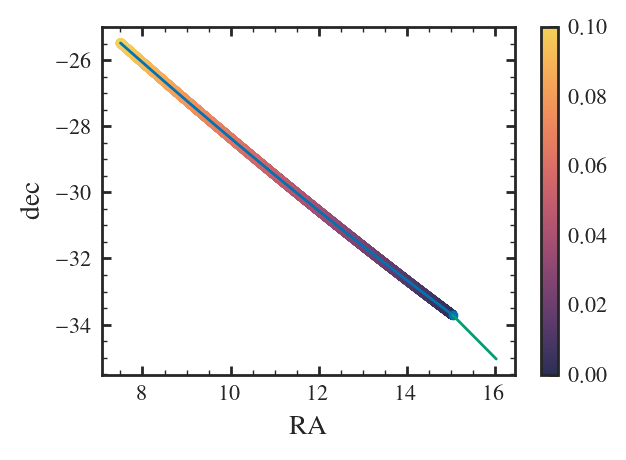

In [387]:
plt.scatter(pos_icrs.ra, pos_icrs.dec, c=ts)
plt.colorbar()

plt.plot(o.ra(ts), o.dec(ts))

plt.scatter(dwarf_galaxy.ra, dwarf_galaxy.dec)


tpm = 3e7*u.yr
plt.plot(sculptor.ra + sculptor.pm_ra_cosdec / np.cos(sculptor.dec) * tpm * np.array([0, 1]),
        sculptor.dec + sculptor.pm_dec * tpm * np.array([0,1]),
         zorder=5, color=arya.COLORS[2]
        )

plt.xlabel("RA")
plt.ylabel("dec")

In [388]:
sc2 = dwarf_galaxy_gc.transform_to(coord.ICRS)

Text(0, 0.5, '$\\mu_\\delta$')

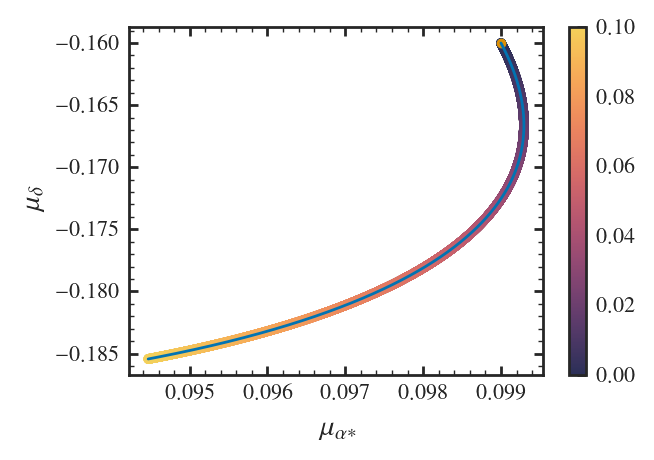

In [389]:
plt.scatter(pos_icrs.pm_ra_cosdec, pos_icrs.pm_dec, c=ts)
plt.colorbar()

plt.scatter(sculptor.pm_ra_cosdec, sculptor.pm_dec)
plt.plot(o.pmra(ts), o.pmdec(ts))
plt.scatter(sc2.pm_ra_cosdec, sc2.pm_dec)

plt.xlabel(r"$\mu_{\alpha*}$")
plt.ylabel(r"$\mu_\delta$")

Text(0, 0.5, 'radial velocity')

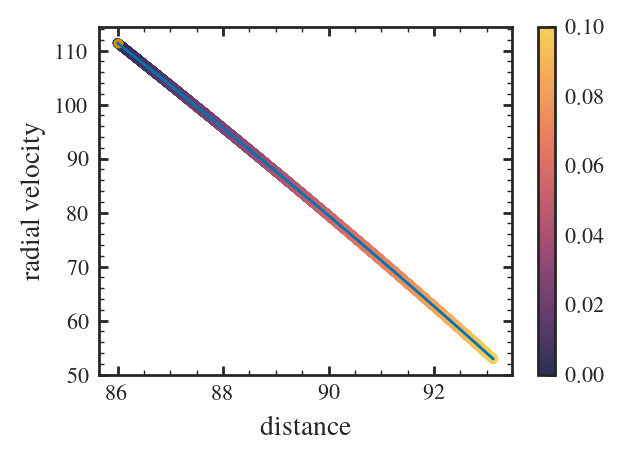

In [391]:
plt.scatter(pos_icrs.distance, pos_icrs.radial_velocity, c=ts)
plt.colorbar()

plt.plot(o.dist(ts), o.vlos(ts))

plt.scatter(sculptor.distance, sculptor.radial_velocity)
plt.scatter(sc2.distance, sc2.radial_velocity)
plt.xlabel(r"distance")
plt.ylabel("radial velocity")

# Orbit plots

In [412]:
def plot_orbit(pot, res=10_000, t_end=10):
    ts = np.linspace(0, -t_end, res) * u.Gyr
    dt = ts[1] - ts[0]

    o.integrate(ts, pot, dt=dt)
    
    peri = np.min(o.r(ts))
    apo = np.max(o.r(ts))
    print("peri = ", peri)
    print("apo = ", apo)
    
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    plt.sca(axs[0])
    plt.plot(o.R(ts), o.z(ts))
    plt.gca().set_aspect(1)
    
    ts2 =np.linspace(0, -min(1, t_end), res) * u.Gyr

    plt.plot(o.R(ts2), o.z(ts2), lw=2)
    plt.scatter(o.R(), o.z(), color=arya.COLORS[3], s=10, zorder=10)
    plt.gca().set_aspect(1)
    
        

    plt.sca(axs[1])

    plt.plot(o.x(ts2), o.y(ts2))
    plt.scatter(o.x(), o.y())
    plt.gca().set_aspect(1)
    plt.show()
    


peri =  53.898203030173875 kpc
apo =  105.07527532015546 kpc


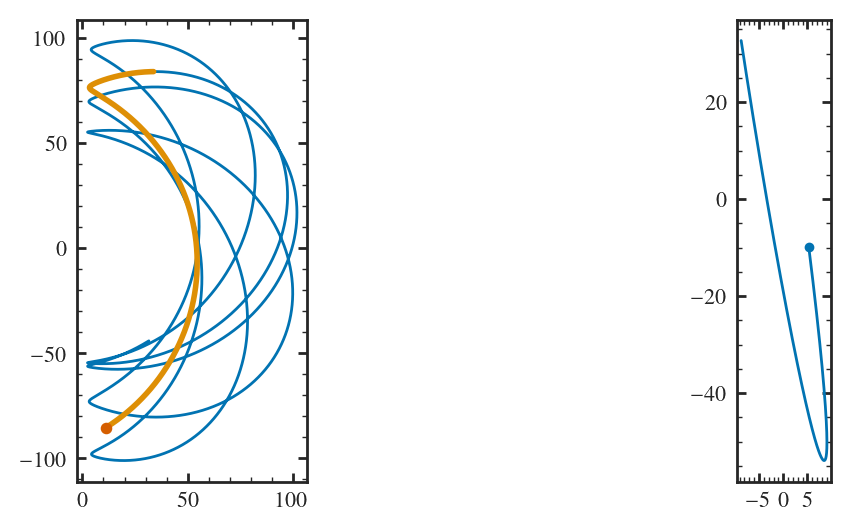

In [413]:
plot_orbit(EP2020)

peri =  79.58495639314344 kpc
apo =  402.10867960827846 kpc


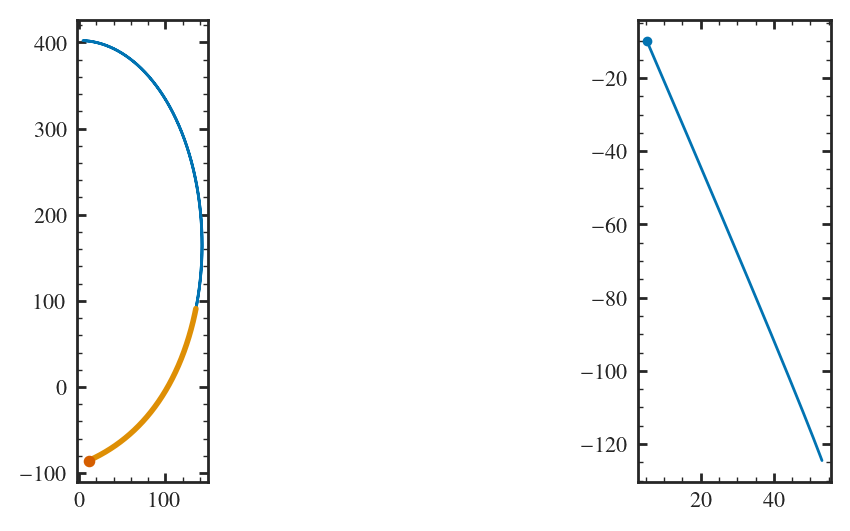

In [50]:
plot_orbit(galpy14)

peri =  72.63697060835713 kpc
apo =  125.0717069634729 kpc


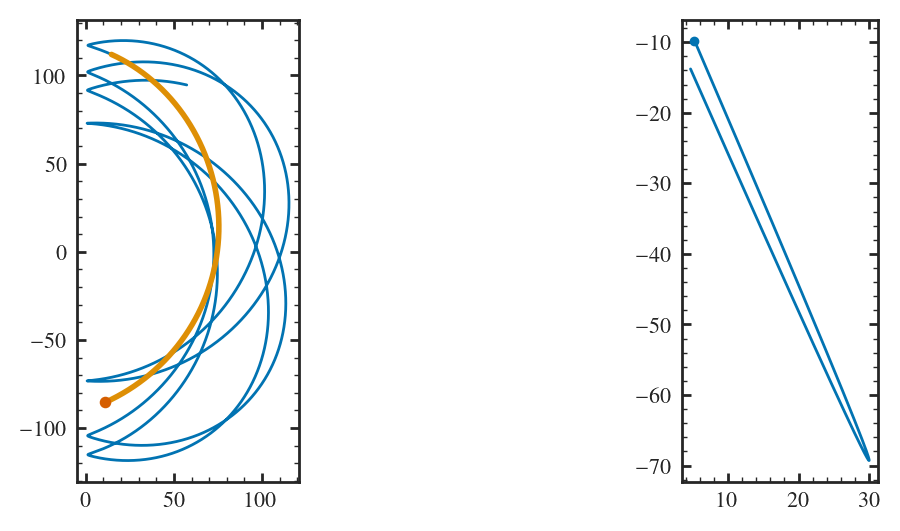

In [51]:
plot_orbit(galpy14_heavy)

In [52]:
plot_orbit(nitschai, res=100, t_end=1)

NameError: name 'nitschai' is not defined

peri =  6.788363102672029 kpc
apo =  56.51272056344877 kpc


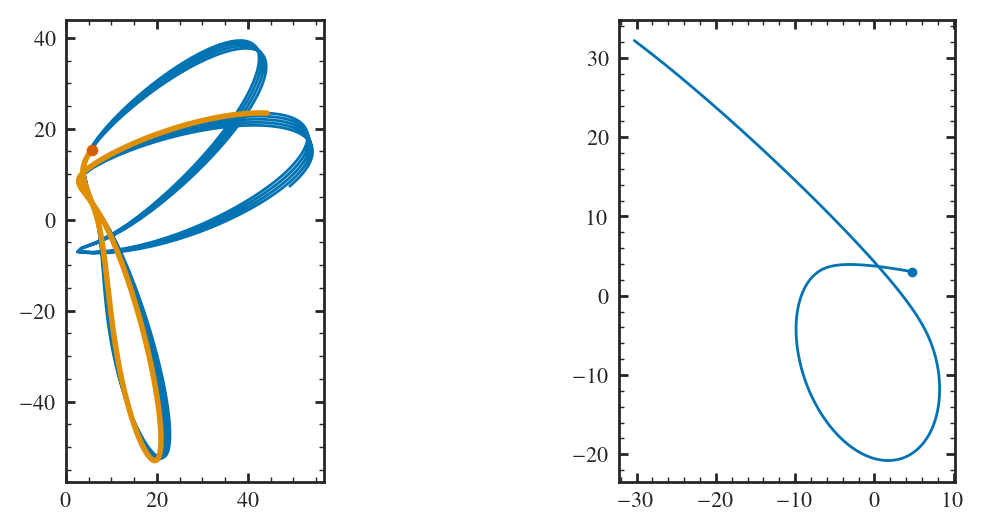

In [137]:
plot_orbit(pouliasis17, res=1000, t_end=10)

peri =  7.466672234887463 kpc
apo =  2258.5897915298683 kpc


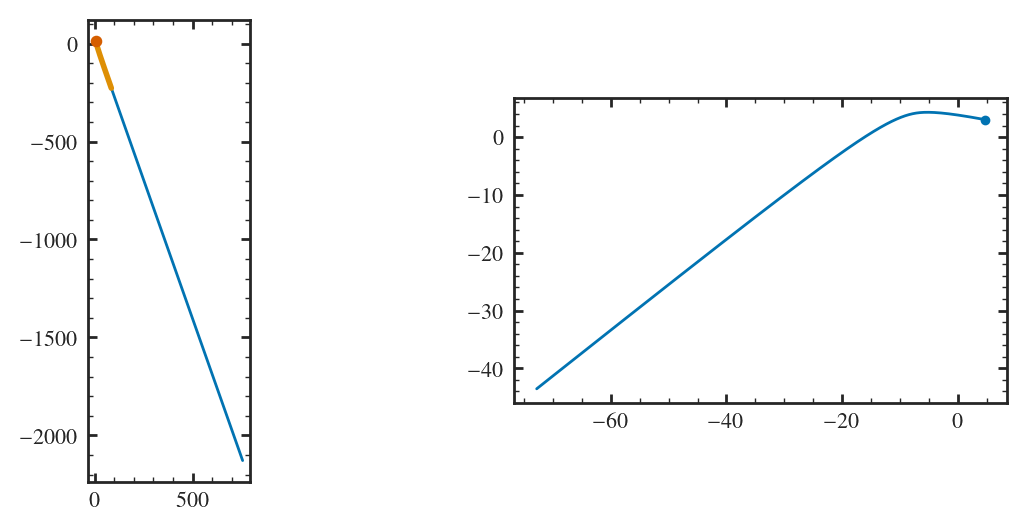

In [138]:
plot_orbit(ablimit20a)

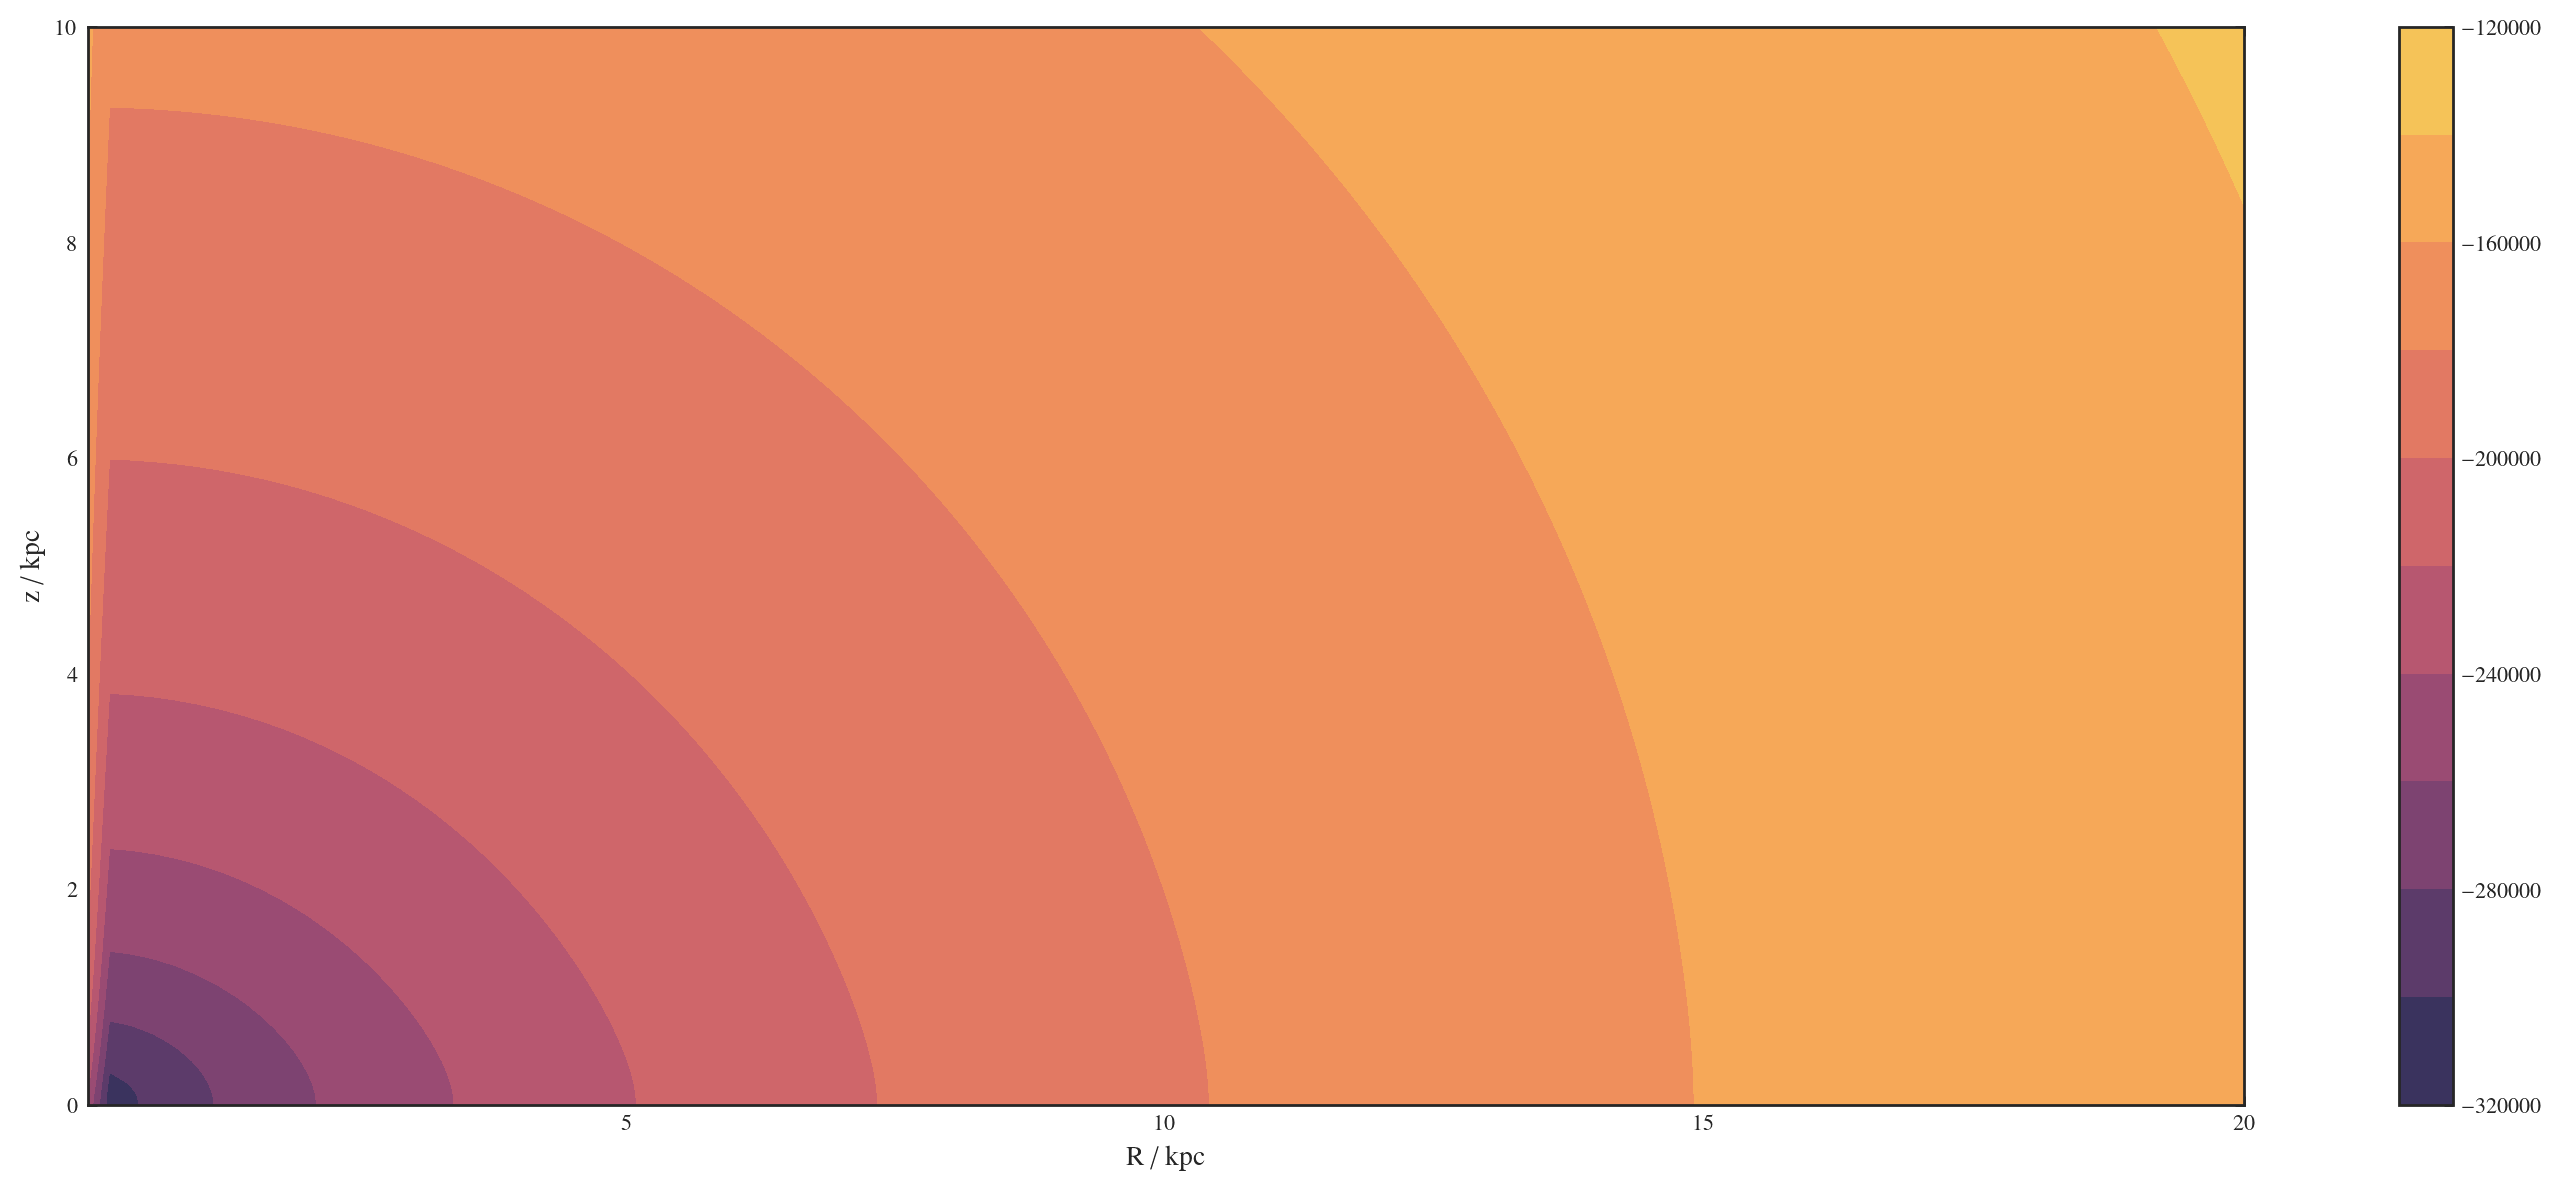

In [139]:
plot_pot_2d(mcmillan2011, R_max=20, z_max=10, res=100)

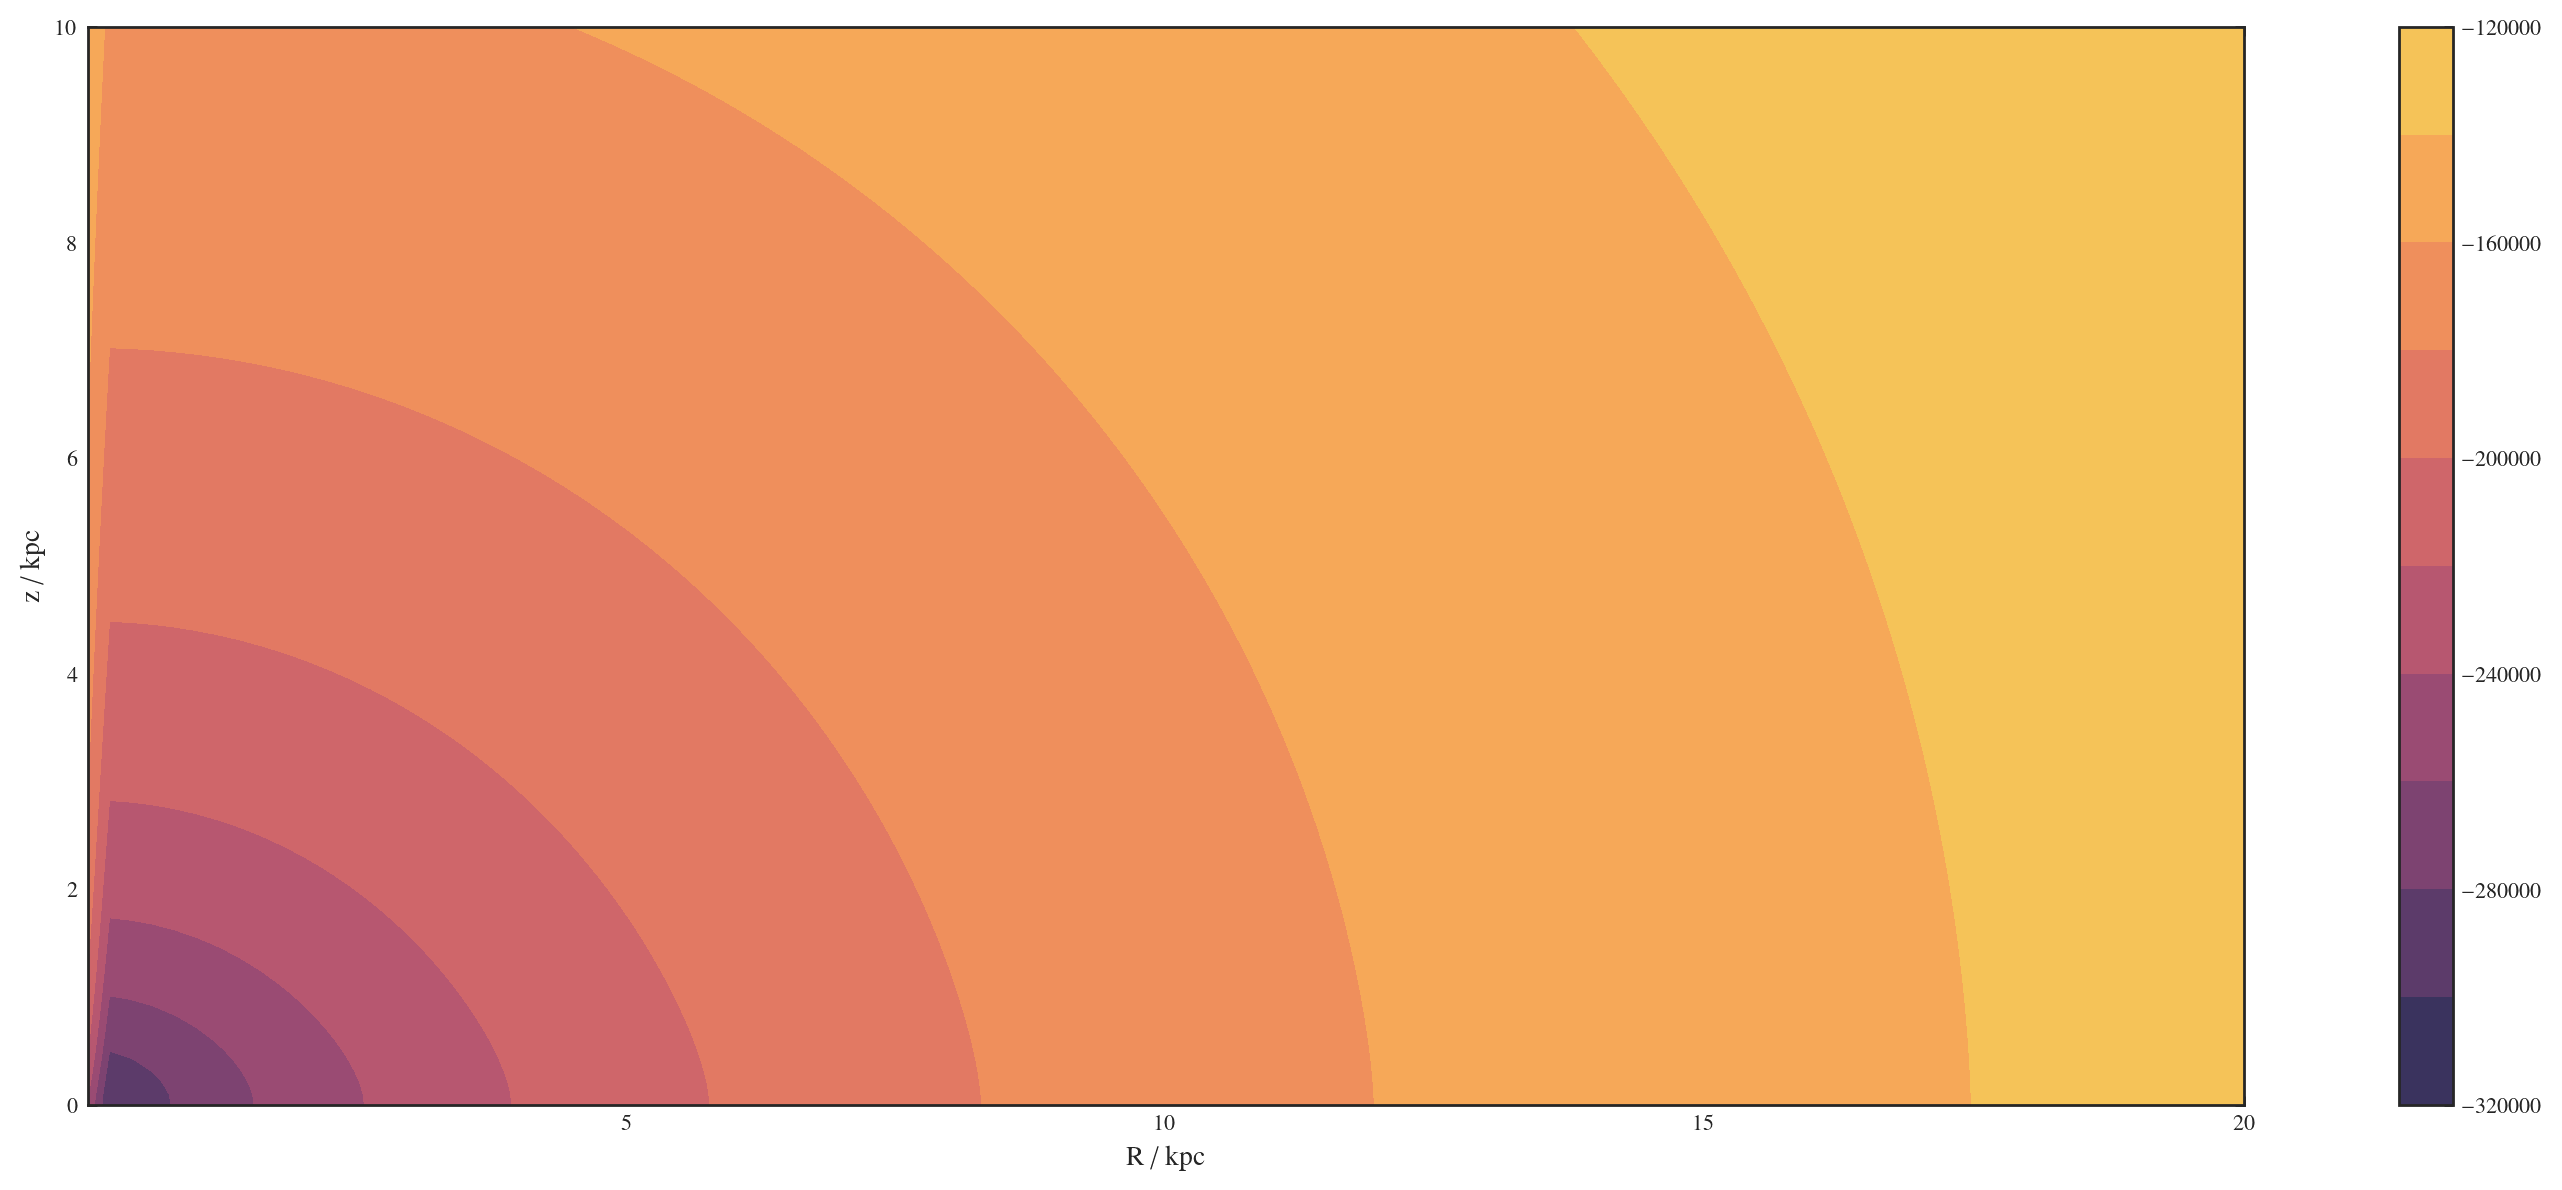

In [140]:
plot_pot_2d(mcmillan2017, R_max=20, z_max=10, res=100)

In [141]:
plot_pot_2d(phi_gp, R_max=20, z_max=10, res=3_000)

NameError: name 'phi_gp' is not defined

# LMC

In [395]:
lmc = coord.SkyCoord(
    ra=80.8942*u.degree, dec=-69.7561*u.degree,                      
    distance=50*u.kpc, radial_velocity=262.2*kms,
    pm_ra_cosdec=1.910*u.mas/u.year, pm_dec=0.229*u.mas/u.year
)                 

In [396]:
lmc_gc = lmc.transform_to(gc_frame)

print(lmc_gc.cartesian.xyz)
print(lmc_gc.velocity.d_xyz)

[ -0.56516902 -41.28803279 -27.14890844] kpc
[ -38.03422135 -228.01301268  230.80961635] km / s


In [397]:
M_lmc=1e11 * u.Msun
r_lmc = 5*u.kpc

In [398]:
friction = gp.ChandrasekharDynamicalFrictionForce(
    GMs=M_lmc, rhm=r_lmc, dens=EP2020)

In [399]:
o_lmc = Orbit(lmc_gc)
times = np.linspace(0, -10, 100_000) * u.Gyr

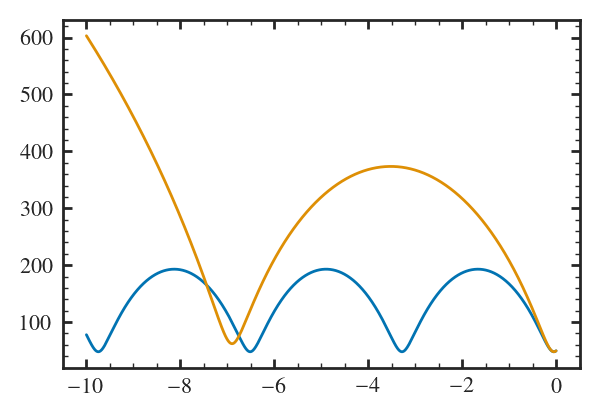

In [400]:
o_lmc.integrate(times, EP2020)
plt.plot(times, o_lmc.r(times))

o_lmc.integrate(times, EP2020 + friction)
plt.plot(times, o_lmc.r(times))


In [401]:
import pandas as pd

lmc_orbit = pd.DataFrame({
    "t": times,
    "x": o_lmc.x(times),
    "y": o_lmc.y(times),
    "z": o_lmc.z(times),
    "vx": o_lmc.vx(times),
    "vy": o_lmc.vy(times),
    "vz": o_lmc.vz(times)
})
lmc_orbit.to_csv("lmc_orbit.csv", index=False)

In [402]:
phi_lmc_s = gp.HernquistPotential(amp=M_lmc, a=r_lmc/(1.+np.sqrt(2.)))
phi_lmc = gp.MovingObjectPotential(o_lmc,pot=phi_lmc_s)

In [403]:
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: gp.evaluateRforces(phi_lmc,loc_origin,0.,phi=0.,t=t,)
ay= lambda t: gp.evaluatephitorques(phi_lmc,loc_origin,0.,phi=0.,t=t,)/loc_origin
az= lambda t: gp.evaluatezforces(phi_lmc,loc_origin,0.,phi=0.,t=t,)

In [404]:
len(o.time(use_physical=False)[::-1])

10000

In [405]:
if o.time(use_physical=False)[0] > o.time(use_physical=False)[1]:
    t_intunits= o.time(use_physical=False)[::-10] # need to reverse the order for interp
else:
    t_intunits= o.time(use_physical=False)[::10]
print(t_intunits.shape)

ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

(1000,)


In [418]:
nip = gp.NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

peri =  53.898203030173875 kpc
apo =  105.07527532015546 kpc


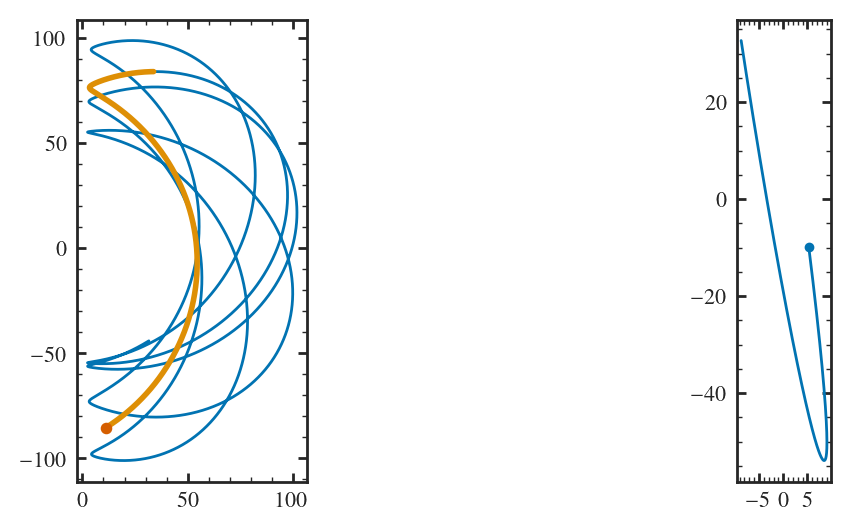

In [414]:
plot_orbit(EP2020)

peri =  48.65501364114026 kpc
apo =  110.99049307499486 kpc


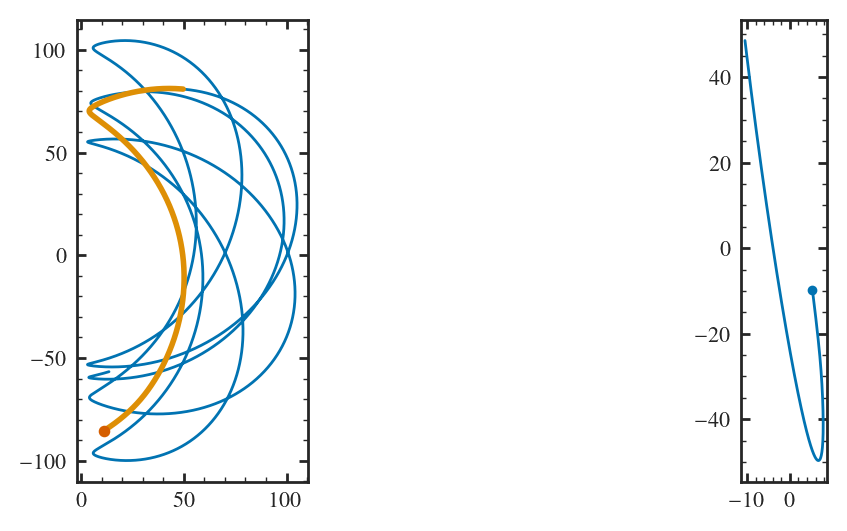

In [415]:
plot_orbit(EP2020 + phi_lmc)

peri =  46.9950724962112 kpc
apo =  126.47685337943108 kpc


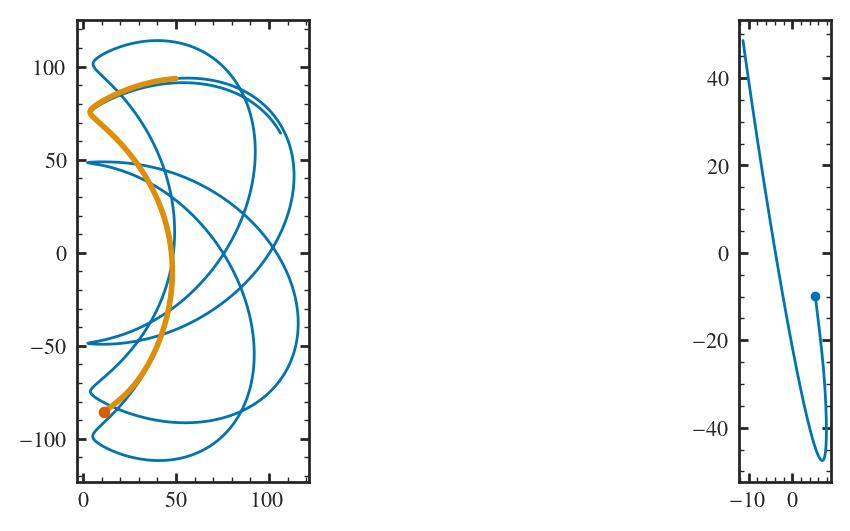

In [416]:
plot_orbit(EP2020 + phi_lmc + nip)

peri =  41.67760222000866 kpc
apo =  138.0197268364967 kpc


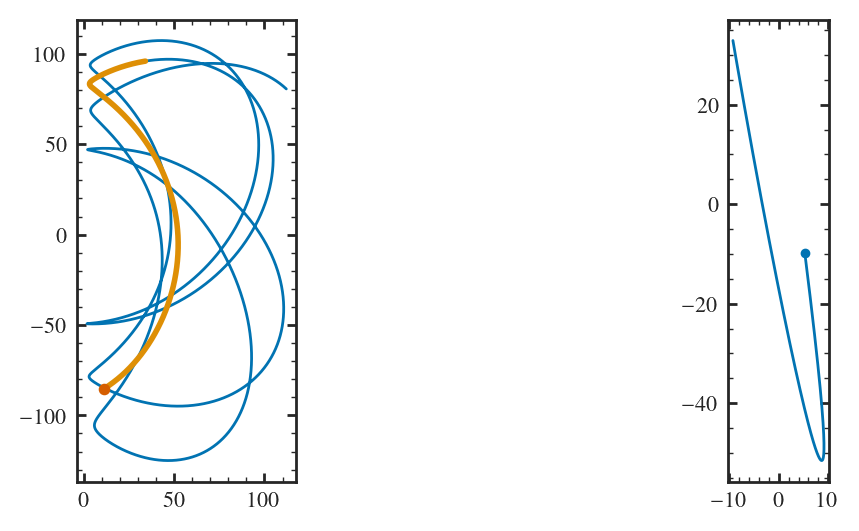

In [417]:
plot_orbit(EP2020 + nip)